<a target="_blank" href="https://colab.research.google.com/github/AngelicaCorrales/recommendation_system_H_M/blob/main/KMeans_H%26M_recomendations_pipelines.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Sistema de recomendación usando K-Means**

Se quiere elaborar un prototipo de un sistema de recomendación de artículos de H&M basado en contenido y teniendo en cuenta el historial de compras de los clientes. 

#**Descargar datasets desde Kaggle**

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

 **Token 1**

In [ ]:
!cp /content/drive/MyDrive/AI/Proyecto_HM/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/AI/Proyecto_HM/kaggle.json': No such file or directory


**Token 2**

In [ ]:
!cp /content/drive/MyDrive/Proyecto_HM/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f transactions_train.csv

100% 584M/584M [00:08<00:00, 68.2MB/s]
100% 584M/584M [00:08<00:00, 76.0MB/s]


In [ ]:
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f customers.csv

 88% 86.0M/97.9M [00:00<00:00, 154MB/s]
100% 97.9M/97.9M [00:00<00:00, 155MB/s]


In [ ]:
! kaggle competitions download h-and-m-personalized-fashion-recommendations -f articles.csv

  0% 0.00/4.26M [00:00<?, ?B/s]
100% 4.26M/4.26M [00:00<00:00, 91.9MB/s]


In [ ]:
!unzip transactions_train.csv.zip

Archive:  transactions_train.csv.zip
  inflating: transactions_train.csv  


In [ ]:
!unzip customers.csv.zip

Archive:  customers.csv.zip
  inflating: customers.csv           


In [ ]:
!unzip articles.csv.zip

Archive:  articles.csv.zip
  inflating: articles.csv            


# **Importar librerías necesarias para la exploración**

In [ ]:
#Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer #Permite obtener la gráfica de las siluetas de cada grupo. 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Preprocesado y modelado
# ==============================================================================
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelEncoder

df_articles = pd.read_csv('articles.csv',na_values='?')
df_transactions = pd.read_csv('transactions_train.csv',na_values='?')
df_customers = pd.read_csv('customers.csv',na_values='?')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Organización y limpieza de los datos**

In [ ]:
#Copias de los dataframes originales para su respectiva modificación
df_custClean=df_customers.copy()
df_tranClean=df_transactions.copy()
df_articles_copy=df_articles.copy() 

In [ ]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

In [ ]:
class DropFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self):
        return self
    def transform(self, df):
        df.drop(columns=self.variables, axis=1, inplace=True)
        return df

In [ ]:
class ValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, column, currentValues, newValue):
        self.column = column
        self.currentValues = currentValues
        self.newValue = newValue
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].replace(self.currentValues, self.newValue, inplace=True)
        return df

In [ ]:
class DropNaNValues(BaseEstimator, TransformerMixin):
    def fit(self):
        return self
    def transform(self, df):
        df=df.dropna()
        df=df.reset_index(drop=True)
        return df    

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, column, factor=1.5):
        self.factor = factor
        self.column=column
    def fit(self):
        return self
    def transform(self, df):
        q1 = np.quantile(df[self.column].values, 0.25)
        q3 = np.quantile(df[self.column].values, 0.75)
        iqr = q3 - q1
        upper_bound = q3 + (self.factor * iqr)
        lower_bound = q1 - (self.factor * iqr)
        outliers = df[self.column].values[(df[self.column].values <= lower_bound) | (df[self.column].values >= upper_bound)]
        if ((outliers.size*100)/(df[self.column].count()))<10:
            df = df[~df[self.column].isin(outliers)]
            df = df.reset_index(drop=True)
        return df

In [ ]:
class DropDuplicatedValues(BaseEstimator, TransformerMixin):
    def fit(self):
        return self
    def transform(self, df):
        df.drop_duplicates()
        df.reset_index(drop=True)
        return df

In [ ]:
class TypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, column, newType):
        self.column=column
        self.newType=newType
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].astype(self.newType)
        return df

In [ ]:
class OneHotEncoderWithDummiesCustom(BaseEstimator, TransformerMixin):
    def __init__(self,columns, prefixes):
        self.columns = columns
        self.prefixes = prefixes
    def fit(self):
        return self
    def transform(self, df):
        for i in range (0,len(self.columns)):
          df = pd.get_dummies(df, columns=[self.columns[i]], prefix=[self.prefixes[i]])
        return df

In [ ]:
class OneHotEncoderWithoutDummiesCustom(BaseEstimator, TransformerMixin):
    def __init__(self,column, ZeroCondition):
        self.column = column
        self.ZeroCondition = ZeroCondition
        self.value= 0
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].replace(self.ZeroCondition, self.value, inplace = True)
        df[self.column].replace(to_replace = r'^(?!'+self.ZeroCondition+').*$', value = 1, regex = True, inplace = True)
        return df

In [ ]:
class LabelEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        
    def fit(self):
        return self
    
    def transform(self, df):
        le = LabelEncoder()
        for i in self.variables:
          df[i] = le.fit_transform(df[i])
        return df

In [ ]:
class termFrecuencyInverseDocumentsFrecuency(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf_tokens=['0241590', '0241602', '0391750', '0391772', '0451290', '05',
       '0504415', '0504416', '0506221', '0507864', '0518647', '0533000',
       '0575442', '0575471', '0683739', '0683740', '0699149', '0700375',
       '0710650', '0712079', '0721929', '0721930', '10', '100', '100x100',
       '100x136', '100x150', '100x180', '100x200', '102', '10cm', '10x10',
       '10x11', '10x12', '10x13', '10x13x19', '10x14', '10x14x19',
       '10x15', '10x17', '10x18x20', '10x18x26', '10x19x25', '10x20x23',
       '10x21x25', '10x21x31', '10x22', '10x22x28', '10x22x30',
       '10x25x34', '10x25x35', '10x27x34', '10x28', '10x29x43',
       '10x34x34', '10x43x43', '10y', '11', '110x110', '110x15',
       '110x200', '114cm', '115', '11x10', '11x110', '11x13', '11x14',
       '11x14cm', '11x16', '11x16x21', '11x16x28', '11x17', '11x17x28',
       '11x18', '11x19x19', '11x20x27', '11x21x26', '11x22x25',
       '11x22x31', '11x24', '11x24x27', '11x24x33', '11x27x37',
       '11x28x32', '11x31x34', '12', '120', '120x190', '123', '125',
       '12m', '12x15', '12x16', '12x16x17', '12x16x19', '12x17',
       '12x19x24', '12x20x20', '12x20x24', '12x22x30', '12x23x28',
       '12x23x40', '12x24x35', '12x25', '12x25x28', '12x28x30',
       '12x28x31', '12x28x44', '12x29x31', '12x30x35', '12x30x40',
       '12x30x46', '12x31x39', '12x32', '12x32x33', '12x33x45',
       '12x34x37', '12x34x49', '12x35x42', '12x35x48', '12x39x48',
       '12x41x54', '12xy', '12y', '13', '130', '130x130', '130x150',
       '130x200', '135', '13x14', '13x15', '13x150', '13x16', '13x17x22',
       '13x19', '13x20x29', '13x22x28', '13x23x23', '13x23x29',
       '13x23x30', '13x23x31', '13x23x32', '13x24', '13x25x29',
       '13x25x32', '13x26x32', '13x26x42', '13x27x35', '13x27x41',
       '13x28x32', '13x28x36', '13x28x38', '13x28x57', '13x29x33',
       '13x29x43', '13x32x33', '13x33x41', '13x34x44', '13x35x38',
       '13x35x42', '13x36x34', '13x40x40', '13x41x57', '14', '140x140',
       '140x150', '14x15', '14x16x30', '14x20x27', '14x24x34', '14x25x32',
       '14x26cm', '14x26x35', '14x27x32', '14x27x46', '14x28', '14x28x29',
       '14x28x30', '14x28x37', '14x28x38', '14x28x45', '14x29', '14x30',
       '14x30x38', '14x30x42', '14x30x43', '14x30x44', '14x30x45',
       '14x31x39', '14x32x39', '14x32x40', '14x33x36', '14x34x35',
       '14x34x40', '14x39x42', '14x45x37', '15', '150', '150x200', '151',
       '158x210', '15x110', '15x126', '15x16', '15x18', '15x19', '15x20',
       '15x20x24', '15x21', '15x22', '15x23x29', '15x24x34', '15x25x32',
       '15x25x35', '15x26x26', '15x27x30', '15x27x35', '15x28x35',
       '15x28x36', '15x28x45', '15x29', '15x29x35', '15x30x36',
       '15x30x42', '15x31', '15x31x37', '15x31x41', '15x31x48',
       '15x31x63', '15x32x46', '15x35x35', '15x40x43', '16', '166',
       '16x20', '16x21', '16x22', '16x23', '16x27x34', '16x28x38',
       '16x29', '16x30x30', '16x30x36', '16x30x39', '16x31x39', '16x32',
       '16x34x40', '16x38', '17', '170x170', '17x17', '17x17x17', '17x23',
       '17x25', '17x25x28', '17x27x44', '17x28x32', '17x28x35',
       '17x30x33', '17x31x35', '17x32', '17x34x36', '17x35x56',
       '17x37x39', '17x38', '17x43x53', '17x44', '18', '180', '180x30',
       '18m', '18x130', '18x23', '18x24', '18x25', '18x26', '18x27x32',
       '18x28x42', '18x28x43', '18x30x45', '18x30x55', '19', '1970s',
       '19x19', '19x27x33', '19x30x39', '19x35x36x50', '19x37x52',
       '19x38x44', '19x42', '1x10x10', '1x15x18', '1x15x22', '1x24x33',
       '1½', '20', '200', '2017', '20x140', '20x20', '20x20x20',
       '20x26x43', '20x27', '20x28', '20x29x39', '20x30x27', '20x30x43',
       '20x35x45', '21', '21x24x48', '21x27', '21x30', '21x30x51',
       '21x31', '21x32', '21x35x48', '21x39x41', '22', '220', '226',
       '22x18x9', '22x26x47', '22x27x48', '22x29', '22x31x48', '22x32',
       '22x32cm', '22x34x40', '22x35', '22x39', '23', '23x27x47', '24',
       '240', '24x26', '24x30x60', '24x34x35', '24x40', '25', '25x15x30',
       '25x160', '25x170', '25x175', '25x180', '25x200', '25x25x52',
       '25x28', '25x35', '25x40', '26', '2600mah', '26x180', '26x19',
       '26x26', '26x33', '26x35', '27', '27x170', '27x180', '27x185',
       '27x190', '27x220', '27x29', '27x31', '28', '28x180', '28x28',
       '28x43', '28x48', '29', '29x35', '2m', '2x', '2x10', '2x10x11',
       '2x10x19', '2x10x20', '2x2', '2x21', '2x25x25', '2x26x34',
       '2x27x36', '2x3', '2x4', '2x5', '2x50', '2x7', '2x8x10', '2x9',
       '2x9x11', '2y', '30', '300', '30x180', '30x198', '30x200',
       '30x250', '30x30', '30x36', '30x36x72', '30x60', '30x80', '31',
       '31x32x18', '31x35', '31x35x13', '31x36', '32', '32x170', '32x180',
       '32x21x25', '32x32', '32x38', '32x50', '33', '33cm', '33x170',
       '33x175', '33x33', '33x36x48', '34', '34x40', '34x44', '35',
       '35x170', '35x175', '35x180', '35x35', '35x39', '35x41', '35x44',
       '35x45', '35x60', '36', '360', '36d', '36x39', '36x52', '37', '38',
       '38b', '39', '39x39', '39x50', '3d', '3x11', '3x12', '3x12x20',
       '3x14', '3x16', '3x17x24cm', '3x19x23', '3x20', '3x21', '3x24',
       '3x3', '3x4', '3x5', '3x6', '3x7', '3x7x11', '3x7x9', '3x8',
       '3x8x10', '3x9', '3x9x12', '3y', '40', '400', '40x140', '40x160',
       '40x170', '40x200', '40x210', '40x211', '40x40', '40x40x15',
       '40x42', '40x44', '40x45', '40x50', '40x55', '41', '42', '43',
       '44', '45', '450', '45x160', '45x185', '45x190', '45x200',
       '45x225', '45x250', '45x45', '46', '460', '47', '48', '48x170',
       '48x200', '49', '490', '4m', '4x10x11', '4x10x13', '4x10x14',
       '4x10x19', '4x11', '4x11x14', '4x11x15', '4x11x18', '4x12x17',
       '4x12x18', '4x12x19', '4x12x20', '4x13', '4x13x16', '4x13x21',
       '4x14x20', '4x14x21', '4x14x22', '4x15x17', '4x15x21', '4x15x27',
       '4x15x28', '4x16x23', '4x16x26', '4x17', '4x17x17', '4x18x28',
       '4x20x27', '4x22x22', '4x25x16', '4x3', '4x4', '4x4x5', '4x6',
       '4x8', '4x9', '4x9x13', '4x9x19', '4y', '50', '500', '50x170',
       '50x175', '50x180', '50x190', '50x200', '50x50', '50x74', '51',
       '52', '52x190', '53', '53x53', '54', '55', '550', '55x160',
       '55x190', '55x210', '55x55', '56', '56x56', '57', '58', '59', '5c',
       '5s', '5x10', '5x100', '5x10x12', '5x10x14', '5x10x15', '5x10x16',
       '5x10x17', '5x10x18', '5x10x19', '5x11', '5x11x13', '5x11x14',
       '5x11x15', '5x11x16', '5x11x17', '5x11x27', '5x12', '5x12x12',
       '5x12x14', '5x12x19', '5x12x20', '5x12x24', '5x13', '5x13x15',
       '5x13x18', '5x13x19', '5x13x20', '5x13x21', '5x13x27', '5x14',
       '5x14x16', '5x14x18', '5x14x19', '5x14x20', '5x14x22', '5x14x30',
       '5x15', '5x15x18', '5x15x19', '5x15x20', '5x15x21', '5x15x23',
       '5x15x25', '5x15x27', '5x16', '5x16x20', '5x16x22', '5x16x23',
       '5x16x25', '5x17', '5x17x21', '5x17x23', '5x17x24', '5x17x30',
       '5x18', '5x18x19', '5x18x23', '5x18x32', '5x19', '5x20', '5x21',
       '5x21x33', '5x22', '5x22x17', '5x23', '5x23x36', '5x24', '5x24x32',
       '5x24x35', '5x26', '5x26x29', '5x27', '5x27x32', '5x27x33',
       '5x27x34', '5x27x38', '5x28', '5x28x28', '5x28x29', '5x28x32',
       '5x28x38', '5x29', '5x29x30', '5x29x35', '5x3', '5x30x30',
       '5x30x35', '5x30x40', '5x30x46', '5x31', '5x31x33', '5x32',
       '5x32x35', '5x32x36', '5x32x37', '5x33', '5x33x36', '5x34', '5x35',
       '5x35x42', '5x36', '5x37', '5x38', '5x39', '5x4', '5x40',
       '5x42x60', '5x43', '5x44', '5x45', '5x49x55', '5x5', '5x5x20',
       '5x6', '5x60', '5x6x20', '5x6x8', '5x6x9', '5x7', '5x7x10', '5x8',
       '5x8x10', '5x8x9', '5x9', '5x9x13', '5x9x17', '5x9x18', '60',
       '600', '60x180', '60x200', '60x60', '61', '62', '63', '63x180',
       '64', '65', '650', '65x180', '65x180cm', '65x195', '65x200',
       '65x65', '66', '66x210', '67', '68', '68x180', '69', '6m', '6s',
       '6x10', '6x10x16', '6x11', '6x11x14', '6x12', '6x12x16', '6x12x19',
       '6x13x19', '6x13x20', '6x13x23', '6x14x19', '6x14x20', '6x15',
       '6x15x19', '6x15x20', '6x15x23', '6x16', '6x16x20', '6x16x24',
       '6x17', '6x17x21', '6x17x30', '6x19x20', '6x2', '6x21', '6x24',
       '6x24x31', '6x7', '70', '70s', '70x170', '70x180', '70x200',
       '70x70', '71', '72', '72x210', '73', '74', '75', '750', '76', '77',
       '78', '7cm', '7x1', '7x10', '7x11', '7x11x13', '7x12', '7x12x15',
       '7x12x17', '7x12x18', '7x12x19', '7x12x30', '7x13', '7x13x18',
       '7x13x20', '7x14', '7x14x17', '7x15', '7x16x19', '7x16x22',
       '7x16x27', '7x16x30', '7x17x15', '7x17x20', '7x17x24', '7x18',
       '7x22x22', '7x23', '7x28x32', '7x31x33', '7x9', '80', '80s',
       '80x100', '80x150', '80x170', '80x180', '80x200', '80x210',
       '80x80', '81', '82', '83', '84', '85', '85x190', '86', '87',
       '87x104', '88', '8cm', '8x', '8x10', '8x11x14', '8x11x17', '8x12',
       '8x13x19', '8x13x23', '8x14x19', '8x14x20', '8x14x25', '8x14x26',
       '8x15', '8x15x18', '8x15x20', '8x15x22', '8x15x23', '8x15x30',
       '8x16', '8x16x23', '8x17', '8x17x22', '8x17x23', '8x18x20',
       '8x18x23', '8x20x30', '8x21', '8x23', '8x24', '8x28x35', '8x30x30',
       '8x30x31', '8x34x50', '8x40x40', '8x8', '8x9', '8y', '90',
       '90x110', '90x170', '90x180', '90x190', '90x200', '90x210',
       '90x90', '91', '92', '95', '95x95', '96', '97', '98', '9m',
       '9x10x15', '9x10x18', '9x12', '9x12x17', '9x13x17', '9x14',
       '9x14x16', '9x15x23', '9x16', '9x18', '9x18x20', '9x18x32', '9x19',
       '9x19x26', '9x20', '9x21', '9x22x30', '9x23', '9x23x26', '9x25',
       '9x27x39', '9x31x39', '9x31x45', '9x35x36', '9x67', '9x7', '9x9',
       'absorbing', 'accentuate', 'accentuated', 'accentuates', 'access',
       'accessories', 'accessory', 'accompanying', 'ace', 'acetate',
       'acrylic', 'activate', 'activated', 'activity', 'acts', 'adapt',
       'add', 'added', 'adding', 'additional', 'address', 'adds',
       'adhesive', 'adjust', 'adjustable', 'adjusted', 'adjustment',
       'adult', 'advent', 'age', 'agriculture', 'aid', 'ain', 'air',
       'airholes', 'airpod', 'airpods', 'airy', 'alabaster', 'algae',
       'alice', 'allow', 'allowing', 'allows', 'alongside', 'alpaca',
       'alternative', 'amber', 'amounts', 'anchor', 'androgynous',
       'angel', 'anglaise', 'angled', 'angles', 'angular', 'animal',
       'ankle', 'ankles', 'anklet', 'anklets', 'anna', 'anorak',
       'antennae', 'anti', 'antiqued', 'antlers', 'apart', 'appearance',
       'apple', 'application', 'applications', 'applicator', 'appliques',
       'appliqué', 'appliquéd', 'appliqués', 'apply', 'approved',
       'approx', 'apron', 'aqua', 'arch', 'area', 'arm', 'armband',
       'armhole', 'armholes', 'armpits', 'arms', 'arrow', 'artificial',
       'astronaut', 'asymmetric', 'athletic', 'attach', 'attached',
       'attaches', 'attachment', 'attachments', 'available', 'aviator',
       'avocado', 'avocados', 'aw20', 'away', 'baby', 'backing',
       'backless', 'backpack', 'backplate', 'backs', 'bad', 'badge',
       'badges', 'bag', 'baggy', 'bags', 'baker', 'balaclava',
       'balconette', 'ball', 'ballerina', 'ballet', 'ballon', 'balloon',
       'balls', 'balm', 'balms', 'bamboo', 'band', 'bandeau', 'bands',
       'bangle', 'bangles', 'bank', 'bar', 'barrel', 'barrette', 'base',
       'baseball', 'based', 'basic', 'basics', 'basketball', 'bat',
       'bath', 'bathing', 'batik', 'battery', 'batwing', 'bauble',
       'beach', 'bead', 'beaded', 'beading', 'beads', 'bear', 'beard',
       'beauty', 'bed', 'bell', 'bellow', 'bellowed', 'bellows', 'bells',
       'belly', 'belongings', 'belt', 'belts', 'bendable', 'bendy',
       'beret', 'bergamot', 'bermuda', 'berries', 'best', 'better', 'bff',
       'bib', 'bibs', 'big', 'bigger', 'biker', 'bikers', 'bikini',
       'bikinis', 'billowing', 'bio', 'biomass', 'black', 'blank',
       'blanket', 'blankets', 'blazer', 'bleach', 'bleached', 'blend',
       'block', 'blood', 'bloom', 'blossom', 'blouse', 'blucher', 'blue',
       'blunt', 'boat', 'bobbles', 'bodice', 'bodies', 'body', 'bodysuit',
       'bodysuits', 'bodywarmer', 'bohemian', 'boiled', 'boiler', 'bold',
       'bolero', 'boleros', 'bomber', 'bonded', 'bone', 'boned', 'bones',
       'boning', 'bonus', 'boost', 'boot', 'bootcut', 'bootees', 'booth',
       'boots', 'border', 'bottle', 'bottles', 'bottoms', 'bouclé',
       'bouse', 'bow', 'bows', 'box', 'boxer', 'boxers', 'boxes', 'boxy',
       'boys', 'bpa', 'bra', 'bracelet', 'bracelets', 'braces', 'braid',
       'braided', 'braiding', 'braids', 'bralette', 'bralettes', 'brand',
       'bras', 'brass', 'brazilian', 'break', 'breast', 'breasted',
       'breathability', 'breathable', 'breathe', 'bride', 'briefs',
       'bright', 'brim', 'bristles', 'brocade', 'broderie', 'brogue',
       'brogues', 'broken', 'brooch', 'brooches', 'brush', 'brushed',
       'bubble', 'bucket', 'buckle', 'buckles', 'bugle', 'built', 'bum',
       'bunch', 'burn', 'burnout', 'bust', 'bustier', 'butterflies',
       'butterfly', 'button', 'buttoned', 'buttonhole', 'buttonholes',
       'buttoning', 'buttons', 'byproduct', 'cable', 'calendar', 'calf',
       'calves', 'camera', 'cami', 'candy', 'cane', 'canopy', 'canvas',
       'canvass', 'cap', 'capacity', 'cape', 'capri', 'caps', 'captain',
       'capture', 'captured', 'car', 'carabiner', 'carat', 'card',
       'cardboard', 'cardigan', 'cardigans', 'cards', 'care', 'carefully',
       'cargo', 'carried', 'carry', 'cars', 'case', 'cashmere', 'casual',
       'cat', 'catch', 'catches', 'catching', 'caught', 'cedar',
       'cellulose', 'central', 'centre', 'certification', 'certified',
       'chain', 'chainmail', 'chains', 'chakra', 'chalk', 'chambray',
       'changes', 'changing', 'character', 'charge', 'charging', 'charm',
       'charms', 'check', 'checked', 'cheeky', 'chelsea', 'chemicals',
       'chen', 'chenille', 'chequered', 'cherries', 'cherry', 'chest',
       'chiffon', 'child', 'children', 'chimi', 'chin', 'chino', 'chinos',
       'chisel', 'chiselled', 'choice', 'choker', 'chokers', 'choose',
       'christmas', 'chukka', 'chunkier', 'chunky', 'cigarette',
       'circular', 'circulation', 'circulose', 'circumference', 'circus',
       'citrus', 'city', 'clad', 'clamdiggers', 'clasp', 'clasps',
       'classic', 'claus', 'claw', 'claws', 'clean', 'cleaner',
       'cleaning', 'clear', 'clearly', 'cleavage', 'click', 'climate',
       'clip', 'clips', 'closable', 'close', 'closed', 'closely',
       'closer', 'closes', 'closure', 'closures', 'cloth', 'clothes',
       'cloud', 'clown', 'clutch', 'cm', 'coach', 'coachella', 'coat',
       'coated', 'coating', 'cobweb', 'coconut', 'cocoon', 'coffee',
       'coil', 'coiled', 'coin', 'cold', 'collar', 'collarless',
       'collection', 'colour', 'coloured', 'colourful', 'colours', 'com',
       'comb', 'combination', 'combined', 'come', 'comes', 'comfort',
       'comfortable', 'comfortably', 'comfy', 'compact', 'company',
       'compartment', 'compartments', 'compatible', 'complete',
       'completely', 'compression', 'compressive', 'comprising',
       'computer', 'computers', 'conceal', 'concealed', 'concealing',
       'conceals', 'concentrated', 'cone', 'connect', 'connected',
       'connector', 'conscious', 'consistent', 'consisting', 'constant',
       'construction', 'consumption', 'contain', 'container',
       'containing', 'contains', 'contemporary', 'content', 'contents',
       'continue', 'continues', 'continuing', 'continuous', 'contours',
       'contrasting', 'contrasts', 'contributing', 'control', 'convert',
       'converted', 'convey', 'cool', 'coolmax', 'coordinated', 'coral',
       'cord', 'corded', 'cords', 'corduroy', 'cork', 'corkscrew',
       'corner', 'corozo', 'corset', 'costume', 'cosy', 'cotton',
       'couple', 'court', 'cover', 'coverage', 'covered', 'covering',
       'covers', 'cowl', 'crackled', 'crayons', 'cream', 'crease',
       'creases', 'create', 'created', 'creates', 'creating', 'creative',
       'creativity', 'credit', 'crescent', 'crimped', 'crinkled', 'crisp',
       'crispy', 'critical', 'crochet', 'crocheted', 'crocodile', 'crop',
       'cropped', 'cross', 'crossed', 'crosses', 'crossover', 'crotch',
       'crown', 'crushed', 'crêpe', 'crêped', 'cube', 'cuddly', 'cuff',
       'cuffed', 'cufflinks', 'cuffs', 'culottes', 'cupro', 'cups',
       'curb', 'curly', 'curved', 'cushion', 'cushioning', 'cuss', 'cut',
       'cutaway', 'cutwork', 'cycling', 'cylindrical', 'damage',
       'damaging', 'dance', 'dangling', 'dares', 'dark', 'darker',
       'darts', 'day', 'days', 'db', 'deck', 'decorate', 'decorated',
       'decoration', 'decorations', 'decorative', 'deep', 'deeper',
       'define', 'defined', 'defines', 'deforestation', 'degree',
       'degrees', 'delicate', 'dempsey', 'denier', 'denim', 'depending',
       'depth', 'derby', 'desert', 'deserve', 'design', 'designed',
       'designs', 'desmond', 'detachable', 'detached', 'detailed',
       'detailing', 'details', 'diagonal', 'diagonally', 'diameter',
       'diamond', 'different', 'diffrent', 'dimensions', 'dinosaur',
       'dinosaurs', 'dip', 'directions', 'dirndl', 'dirt', 'dirty',
       'disappear', 'disc', 'discolouration', 'discreet', 'discreetly',
       'discs', 'disk', 'distinctive', 'divide', 'divided', 'divides',
       'dmf', 'dobby', 'does', 'doesn', 'dog', 'dogtooth', 'dolman',
       'dolphin', 'donut', 'door', 'double', 'doubled', 'doubles',
       'doughnut', 'downwards', 'dragon', 'dramatic', 'dramatically',
       'drape', 'draped', 'drapes', 'draping', 'drawstring',
       'drawstrings', 'dress', 'dressed', 'dresses', 'dressing', 'dressy',
       'drip', 'drop', 'dropped', 'dry', 'drying', 'duchesse', 'duffle',
       'dungaree', 'dungarees', 'dust', 'dyed', 'dyeing', 'dyes', 'ear',
       'earflaps', 'earmuffs', 'earphone', 'earring', 'earrings', 'ears',
       'ease', 'easier', 'easily', 'eastman', 'easy', 'eccentric',
       'eclectic', 'ecomade', 'econyl', 'edge', 'edged', 'edges',
       'edition', 'effect', 'effective', 'effectively', 'effects',
       'efficiently', 'eggs', 'elastane', 'elastic', 'elasticated',
       'elastication', 'elastics', 'elbow', 'elbows', 'elegant', 'elf',
       'elongated', 'embellished', 'embellishment', 'emblem', 'embossed',
       'embrace', 'embroidered', 'embroidery', 'emma', 'emojis',
       'emphasise', 'empire', 'en', 'enable', 'enabling', 'enamelled',
       'encircling', 'enclose', 'enclosed', 'encouraging', 'end', 'ended',
       'ending', 'endorse', 'ends', 'energy', 'engraved', 'enhance',
       'enter', 'entire', 'entirely', 'envelope', 'environment',
       'enzymes', 'epaulettes', 'era', 'erasers', 'espadrille',
       'espadrilles', 'essentials', 'ethylene', 'eva', 'evening',
       'example', 'excluding', 'exclusive', 'exercising', 'existing',
       'expansion', 'extend', 'extended', 'extenders', 'extending',
       'extends', 'extensions', 'extra', 'extracted', 'extremes', 'eye',
       'eyelet', 'eyelets', 'eyes', 'eyewear', 'fabric', 'fabrics',
       'face', 'faces', 'faceted', 'facing', 'factor', 'factory', 'fade',
       'fairtrade', 'fairy', 'fake', 'fall', 'false', 'fancy', 'fashion',
       'fashioned', 'fast', 'fasten', 'fastened', 'fastener', 'fasteners',
       'fastening', 'fastenings', 'fastens', 'faux', 'favourite', 'fear',
       'fearless', 'feather', 'feathered', 'featherlight', 'feathers',
       'feature', 'featuring', 'feel', 'feeling', 'feet', 'felt',
       'felted', 'fertilisers', 'festive', 'fiber', 'fibre', 'fibres',
       'fil', 'filigree', 'filled', 'filling', 'filters', 'fin', 'finds',
       'fine', 'finely', 'finer', 'finger', 'fingerless', 'fingers',
       'fingertips', 'finish', 'finished', 'finishes', 'finishing',
       'firm', 'firmer', 'firmly', 'fish', 'fisherman', 'fishing',
       'fishnet', 'fishtail', 'fit', 'fits', 'fitted', 'fitting', 'fixed',
       'flamingo', 'flamingos', 'flannel', 'flap', 'flaps', 'flare',
       'flared', 'flares', 'flash', 'flashes', 'flashing', 'flat',
       'flatlock', 'flats', 'flattering', 'flavour', 'flavoured',
       'flavours', 'fleece', 'flexi', 'flexible', 'flip', 'flippy',
       'floaty', 'flock', 'floppy', 'flops', 'floral', 'flounce',
       'flounced', 'flounces', 'flow', 'flower', 'flowers', 'fluffy',
       'fluorocarbons', 'fluted', 'fluting', 'flutter', 'fluttery', 'fly',
       'flying', 'foam', 'focuses', 'foil', 'fold', 'foldable',
       'foldaway', 'folded', 'folding', 'foldover', 'folds', 'follow',
       'follows', 'foot', 'football', 'footless', 'footmuff', 'footwear',
       'forearms', 'form', 'formal', 'forming', 'forms', 'formula',
       'forward', 'founded', 'fragrance', 'frame', 'framed', 'frames',
       'frayed', 'free', 'freefit', 'freesia', 'french', 'fresh',
       'freshwater', 'friction', 'fried', 'friend', 'friends',
       'friendship', 'fries', 'frill', 'frilled', 'frills', 'fringe',
       'fringed', 'fringes', 'fringing', 'frog', 'fronted', 'fronts',
       'frosted', 'fruit', 'fruity', 'fuller', 'fullness', 'fully',
       'function', 'functional', 'functions', 'funnel', 'fur', 'fuzzy',
       'gap', 'garment', 'garments', 'garter', 'gather', 'gathered',
       'gathers', 'geared', 'gel', 'gemstones', 'generous', 'gentle',
       'gently', 'geometric', 'georgette', 'gift', 'gilet', 'gingham',
       'giraffe', 'given', 'gives', 'giving', 'glare', 'glass', 'glasses',
       'glistening', 'glitter', 'glittery', 'globe', 'glossy', 'glove',
       'glover', 'gloves', 'glow', 'glows', 'glued', 'goes', 'goggles',
       'going', 'gold', 'good', 'gore', 'gores', 'gown', 'gp',
       'gradually', 'grained', 'grammes', 'grand', 'grandad', 'grapes',
       'grease', 'greater', 'green', 'grey', 'grip', 'grippy', 'grips',
       'grosgrain', 'growing', 'grown', 'grows', 'gsm', 'guarantees',
       'guard', 'guards', 'guitar', 'guppyfriend', 'gusset', 'gym',
       'hair', 'hairband', 'hairbands', 'hairbrush', 'hairclip',
       'hairclips', 'haired', 'half', 'halfway', 'halo', 'halter',
       'halterneck', 'halves', 'hamburger', 'hamburgers', 'hammer',
       'hammered', 'hand', 'handbag', 'handfeel', 'handkerchief',
       'handle', 'handles', 'handmade', 'hands', 'handwarmer', 'handy',
       'hang', 'hanger', 'hanging', 'hard', 'harem', 'harlequin', 'hat',
       'hats', 'head', 'headband', 'headbands', 'headphone', 'headphones',
       'headwear', 'heals', 'hearing', 'heart', 'hearts', 'heat',
       'heavier', 'heavily', 'heavy', 'heavyweight', 'heel', 'heeled',
       'heels', 'height', 'held', 'helmet', 'help', 'helping', 'helps',
       'hem', 'hemmed', 'hems', 'hemstitch', 'hemstitched',
       'hemstitching', 'henley', 'herring', 'herringbone', 'hexagonal',
       'hi', 'hidden', 'hide', 'high', 'higher', 'highest', 'highs',
       'hinges', 'hip', 'hips', 'hipster', 'hm', 'hobo', 'hold', 'holder',
       'holders', 'holding', 'holds', 'hole', 'holes', 'hologram',
       'holographic', 'hood', 'hooded', 'hoodie', 'hoodies', 'hoof',
       'hook', 'hooks', 'hoop', 'hoops', 'hooves', 'hope', 'horizontal',
       'horizontally', 'horn', 'horns', 'horseshoe', 'hot', 'hotpants',
       'hottest', 'hours', 'hung', 'hyacinth', 'ice', 'iconic',
       'identity', 'imitation', 'immitation', 'impact', 'impregnating',
       'impression', 'impressive', 'incision', 'included', 'includes',
       'including', 'incorporate', 'incorporated', 'incorporates',
       'increased', 'indented', 'index', 'individual', 'individually',
       'indoor', 'infill', 'information', 'ink', 'inner', 'innovative',
       'input', 'inscribed', 'insert', 'inserts', 'inset', 'insets',
       'inside', 'insides', 'insole', 'insoles', 'inspired', 'instead',
       'instructions', 'insulation', 'intarsia', 'integral', 'intensity',
       'interactive', 'interchangeable', 'interlinked', 'internal',
       'intertwined', 'invisible', 'invisibly', 'ipad', 'iphone',
       'iphones', 'iron', 'ironed', 'italian', 'items', 'jacked',
       'jacket', 'jackets', 'jacquard', 'jayne', 'jazz', 'jeans',
       'jeggings', 'jersey', 'jetted', 'jewellery', 'jodhpur', 'joggers',
       'join', 'joined', 'juice', 'jumper', 'jumpers', 'jumpsuit', 'just',
       'justine', 'jute', 'kaftan', 'kangaroo', 'kangol', 'karolina',
       'kate', 'keeping', 'keeps', 'kelzuki', 'key', 'keyhole', 'keyring',
       'keys', 'kg', 'kick', 'kickflare', 'kids', 'kijak', 'kimono',
       'kit', 'kitten', 'knee', 'knees', 'knit', 'knitted', 'knitting',
       'knob', 'knot', 'knots', 'knotted', 'knuckles', 'label', 'lace',
       'laced', 'laces', 'lacing', 'lacquered', 'ladder', 'lakes',
       'lambswool', 'lanyard', 'lapel', 'lapels', 'lapped', 'laptop',
       'laptops', 'large', 'larger', 'largest', 'laser', 'lastingfit',
       'latex', 'laundry', 'lavender', 'layer', 'layered', 'layers',
       'lead', 'leading', 'leaf', 'lease', 'leash', 'leather',
       'leatherette', 'leave', 'leaves', 'led', 'left', 'leg', 'legged',
       'leggings', 'legs', 'lemon', 'length', 'length13', 'lengths',
       'lens', 'lenses', 'lenticular', 'leopard', 'leotard', 'let',
       'letter', 'letters', 'level', 'levels', 'lid', 'lids', 'life',
       'lift', 'light', 'lighter', 'lightly', 'lightning', 'lights',
       'lightweight', 'like', 'limited', 'limiter', 'line', 'lined',
       'linen', 'liner', 'lining', 'linings', 'link', 'linked', 'links',
       'lint', 'lion', 'lip', 'lips', 'lipstick', 'liquid', 'lithium',
       'little', 'live', 'loafers', 'lobster', 'lock', 'locks', 'logo',
       'logos', 'long', 'longer', 'longest', 'longjohns', 'look', 'looms',
       'loop', 'loops', 'loose', 'loosely', 'loosened', 'looser', 'lots',
       'lounge', 'loungewear', 'love', 'loves', 'low', 'lower', 'lowest',
       'luggage', 'luminescent', 'lustrous', 'lycra', 'lyocell', 'lété',
       'machine', 'macramé', 'magic', 'magnetic', 'magnets',
       'magnification', 'main', 'mainly', 'maintain', 'make', 'makeup',
       'making', 'mandarin', 'mane', 'mango', 'manufactured',
       'manufacturing', 'marble', 'marbled', 'marked', 'marker',
       'marking', 'marl', 'marled', 'mask', 'masks', 'mat', 'match',
       'matching', 'material', 'materials', 'matt', 'matte', 'maxi',
       'maximise', 'maximum', 'maybe', 'mean', 'means', 'measure',
       'medallion', 'medium', 'meet', 'meets', 'mend', 'mercerised',
       'merino', 'mermaid', 'mesh', 'metal', 'metallic', 'metres',
       'micro', 'microfibre', 'microplastics', 'mid', 'middle',
       'midsoles', 'mighetto', 'minaj', 'mini', 'minimal', 'minimalistic',
       'minimise', 'minimises', 'minimum', 'minutes', 'mirror',
       'mirrored', 'mistletoe', 'mitten', 'mittens', 'mitts', 'mixed',
       'ml', 'mm', 'mobile', 'mobility', 'moccasin', 'moccasins', 'modal',
       'modern', 'mohair', 'moire', 'moist', 'moisten', 'moisture',
       'moisturising', 'monkstraps', 'monster', 'months', 'moon',
       'morgan', 'morris', 'mosaic', 'moss', 'moths', 'motif', 'motifs',
       'motion', 'mould', 'moulded', 'moulds', 'mouth', 'movable',
       'movement', 'moving', 'mrs', 'mug', 'mulberry', 'mule', 'mules',
       'multi', 'multicoloured', 'multifunctional', 'multiple',
       'multistretch', 'multiway', 'muscle', 'mushroom', 'musk', 'muslin',
       'naia', 'nail', 'nappa', 'napped', 'narrow', 'narrower',
       'narrowing', 'narrows', 'narrrow', 'nasa', 'nathalie', 'natural',
       'nearest', 'neat', 'necessary', 'neck', 'necked', 'necklace',
       'necklaces', 'neckline', 'necklines', 'need', 'needles',
       'negligee', 'neon', 'nepped', 'net', 'nets', 'neutral', 'new',
       'newborn', 'newborns', 'newcell', 'nick', 'nicki', 'nightdress',
       'nightdresses', 'nightshirt', 'nightslip', 'nipple', 'non',
       'normal', 'nose', 'notch', 'note', 'notebook', 'notes', 'nubuck',
       'number', 'numbers', 'nursing', 'nut', 'nylon', 'objects',
       'oblique', 'oblong', 'oceans', 'octagonal', 'odds', 'offering',
       'offset', 'old', 'ombre', 'ones', 'ons', 'opaque', 'open',
       'opened', 'opening', 'openings', 'opens', 'optimal', 'optimum',
       'orange', 'orb', 'organic', 'organza', 'origin', 'ottoman',
       'outdoor', 'outdoors', 'outer', 'outerwear', 'outfit', 'outlet',
       'outlined', 'output', 'outs', 'outside', 'outsides', 'oval',
       'overdimensioned', 'overdress', 'overlap', 'overlapping',
       'overlayered', 'overlocked', 'oversized', 'overview', 'owl',
       'oxford', 'pack', 'packaging', 'packed', 'padded', 'padding',
       'padlock', 'pads', 'paint', 'painted', 'paints', 'pair', 'pairs',
       'paisley', 'palazzo', 'palm', 'palms', 'pan', 'panel', 'panels',
       'pants', 'paper', 'parakeets', 'parcel', 'pared', 'parent',
       'parka', 'partial', 'partially', 'parties', 'partly', 'parts',
       'party', 'pass', 'passport', 'pastel', 'patch', 'patched',
       'patches', 'patchouli', 'patent', 'pattened', 'pattern',
       'patterned', 'patterns', 'paws', 'pea', 'peak', 'pearl', 'pearls',
       'pearly', 'peel', 'peep', 'pencil', 'pencils', 'pendant',
       'pendants', 'pennants', 'peplum', 'perfect', 'perforated',
       'performing', 'period', 'permeability', 'personal', 'pesticides',
       'pests', 'pet', 'peta', 'petal', 'peter', 'phone', 'phones',
       'phosphates', 'photo', 'photographic', 'phthalate', 'physique',
       'picot', 'piece', 'pieces', 'pierced', 'piercing', 'pile',
       'pillow', 'pima', 'pin', 'pineapple', 'pineapples', 'pink', 'pins',
       'pinstriped', 'piped', 'piping', 'piqué', 'pirate', 'pistol',
       'pixelated', 'pixie', 'pizza', 'piñatex', 'place', 'places',
       'placket', 'plackets', 'plain', 'plasters', 'plastic', 'plastics',
       'plate', 'plated', 'plates', 'platform', 'platforms', 'plays',
       'playsuit', 'pleat', 'pleated', 'pleating', 'pleats', 'plenty',
       'plexiglass', 'plumeti', 'plus', 'pocket', 'pockets', 'point',
       'pointed', 'pointelle', 'points', 'polarised', 'polish',
       'polished', 'polo', 'polyamide', 'polyester', 'polyurethane',
       'pompom', 'pompoms', 'poncho', 'ponytail', 'pool', 'poolside',
       'pop', 'popcorn', 'poplin', 'popover', 'porcini', 'positions',
       'post', 'pot', 'pouch', 'pouches', 'practical', 'practising',
       'prawn', 'pre', 'precious', 'pregnancy', 'premium', 'premum',
       'press', 'pressed', 'pressure', 'preventing', 'princess', 'print',
       'printed', 'prints', 'pro', 'process', 'produced', 'product',
       'production', 'products', 'profile', 'prolong', 'prominent',
       'proof', 'properties', 'prostheses', 'protect', 'protection',
       'protective', 'protector', 'protectors', 'protects', 'provide',
       'provides', 'providing', 'puff', 'puffed', 'puffer', 'puffy',
       'pull', 'pulled', 'pulling', 'pump', 'pumpkin', 'pumpkins',
       'pumps', 'punch', 'punched', 'purely', 'purl', 'purse', 'push',
       'pushchair', 'pussy', 'pyjama', 'pyjamas', 'quality', 'quick',
       'quickly', 'quilted', 'quilting', 'rabbit', 'rabbits', 'racer',
       'raffia', 'raglan', 'rain', 'rainbow', 'raised', 'rami', 'ramie',
       'ranging', 'rash', 'raspberry', 'rattan', 'rattle', 'raw', 'rayon',
       'real', 'rebellious', 'rechargeable', 'reconstituted',
       'rectangular', 'recycle', 'recycled', 'red', 'reduced', 'reduces',
       'reducing', 'reduction', 'reefer', 'refillable', 'reflective',
       'regenerated', 'regular', 'regulates', 'regulating',
       'rehabilitation', 'reindeer', 'reinforced', 'reinforcement',
       'reinforcements', 'reinforcing', 'related', 'relax', 'relaxed',
       'relaxes', 'relaxing', 'relief', 'remnants', 'removable', 'remove',
       'removed', 'remover', 'removes', 'renu', 'repair', 'repeat',
       'repel', 'repellent', 'repurposed', 'required', 'requirements',
       'resembling', 'resin', 'resistance', 'resistant', 'resort',
       'resources', 'restore', 'results', 'retain', 'retaining', 'retro',
       'reusable', 'reused', 'reveal', 'reverse', 'reversed',
       'reversible', 'rhinestone', 'rhinestones', 'rhomboid', 'rib',
       'ribbed', 'ribbing', 'ribbon', 'ribbons', 'richly', 'right',
       'rigid', 'rim', 'rimless', 'rimmed', 'ring', 'rings', 'ripped',
       'ripper', 'rippled', 'rips', 'rise', 'risk', 'rivers', 'robust',
       'rock', 'rod', 'rods', 'roll', 'rolled', 'roller', 'romper',
       'rooftop', 'room', 'roomy', 'rope', 'rose', 'roses', 'rotated',
       'rotation', 'round', 'rounded', 'row', 'rows', 'rub', 'rubber',
       'ruffle', 'ruffled', 'ruffles', 'rugby', 'run', 'running', 'runs',
       'rustle', 'rustling', 'rustly', 'sack', 'saddle', 'safe', 'safety',
       'sailor', 'sandals', 'sandpaper', 'santa', 'sarong', 'sash',
       'satin', 'save', 'saves', 'scale', 'scales', 'scallop',
       'scalloped', 'scalloping', 'scarf', 'scarves', 'scary', 'scent',
       'scented', 'scissors', 'scoop', 'scratch', 'screw', 'scrunchie',
       'scrunchies', 'scuba', 'sculpting', 'sculpts', 'seagrass',
       'sealable', 'sealed', 'seam', 'seamed', 'seamless', 'seams',
       'search', 'seat', 'second', 'section', 'sections', 'secure',
       'secured', 'securing', 'security', 'seersucker', 'segmented',
       'select', 'self', 'selfie', 'selvedge', 'semi', 'separate',
       'separately', 'sequin', 'sequined', 'sequins', 'set', 'sets',
       'seven', 'sewing', 'sewn', 'shacket', 'shade', 'shades', 'shaft',
       'shaftless', 'shafts', 'shake', 'shame', 'shampoo', 'shape',
       'shaped', 'shapes', 'shaping', 'share', 'sharp', 'sharply',
       'shawl', 'shearling', 'sheen', 'sheep', 'sheepskin', 'sheer',
       'sheet', 'sheets', 'shell', 'shells', 'shimmer', 'shimmering',
       'shine', 'shiny', 'shirt', 'shirts', 'shoe', 'shoelaces', 'shoes',
       'shopper', 'short', 'shorten', 'shorter', 'shortie', 'shorts',
       'shorty', 'shoulder', 'shoulders', 'showcase', 'showcases',
       'shower', 'showers', 'showing', 'shut', 'shuttle', 'sided',
       'sidepiece', 'sidepieces', 'sides', 'sightly', 'signet',
       'silhouette', 'silicon', 'silicone', 'silk', 'silky', 'silver',
       'simple', 'single', 'size', 'size7x23x26', 'sized', 'sizes',
       'skater', 'skeleton', 'skeletons', 'ski', 'skin', 'skinny',
       'skirt', 'skirts', 'skit', 'skull', 'skulls', 'skye', 'slanted',
       'sleep', 'sleeping', 'sleeve', 'sleeved', 'sleeveless', 'sleeves',
       'slice', 'slices', 'slide', 'sliders', 'slides', 'sliding',
       'slight', 'slightly', 'slim', 'slimmer', 'slingback', 'slingbacks',
       'slip', 'slipover', 'slipper', 'slippers', 'slit', 'slits',
       'slope', 'sloping', 'slot', 'sloth', 'slots', 'slub', 'small',
       'smaller', 'smallest', 'smart', 'smarten', 'smartphone',
       'smartphones', 'smock', 'smocked', 'smocking', 'smooth',
       'smoother', 'snaffle', 'snake', 'snakes', 'snakeskin', 'snap',
       'snow', 'snowflakes', 'snugly', 'sock', 'socket', 'socks', 'soft',
       'softer', 'softly', 'softshell', 'sole', 'soled', 'soles', 'solid',
       'sorts', 'souls', 'space', 'spacious', 'spaghetti', 'sparkling',
       'sparklingly', 'sparkly', 'special', 'speech', 'speed', 'spell',
       'spheres', 'spherical', 'spider', 'spiders', 'spill', 'spiral',
       'splatter', 'split', 'sponge', 'spooky', 'sport', 'sports',
       'sportswear', 'sporty', 'spot', 'spots', 'spotted', 'spout',
       'spray', 'spread', 'sprig', 'square', 'stability', 'stain',
       'stainless', 'stains', 'stalk', 'stalks', 'stand', 'staple',
       'staples', 'star', 'starfish', 'stars', 'start', 'stash', 'stay',
       'stays', 'steel', 'stem', 'step', 'stick', 'stickers', 'stiff',
       'stiletto', 'stirrups', 'stitch', 'stitched', 'stitches',
       'stitching', 'stocking', 'stockings', 'stomach', 'stone', 'stones',
       'stopper', 'stops', 'storage', 'stored', 'stories', 'storing',
       'storm', 'straight', 'straighter', 'strand', 'strands', 'strap',
       'strapless', 'strappy', 'straps', 'straw', 'strawberry', 'streaks',
       'streetwear', 'stretch', 'stretched', 'stretches', 'stretching',
       'stretchy', 'strewn', 'string', 'strip', 'stripe', 'striped',
       'stripes', 'strips', 'stronger', 'structure', 'stud', 'studded',
       'studier', 'studio', 'studs', 'study', 'stuff', 'stuffed',
       'sturdier', 'sturdy', 'stye', 'style', 'styled', 'styles',
       'stylish', 'substances', 'subtle', 'subtly', 'suede', 'suit',
       'suitable', 'suits', 'summer', 'summery', 'sun', 'sunburst',
       'suncream', 'sunglasses', 'sunhat', 'sunny', 'super', 'superior',
       'superskinny', 'supersoft', 'superstretch', 'supple', 'supplied',
       'support', 'supports', 'supreme', 'surf', 'surface', 'surfboard',
       'surrounded', 'suspended', 'suspender', 'suspenders',
       'sustainable', 'sustainably', 'sweatband', 'sweater', 'sweatpant',
       'sweatpants', 'sweatshirt', 'sweden', 'sweetheart', 'swim',
       'swimming', 'swimsuit', 'swimsuits', 'swimwear', 'swivel',
       'synchronisation', 'synthetic', 'tab', 'tabs', 'tack', 'taffeta',
       'tag', 'tags', 'tail', 'tailored', 'tails', 'takeaway', 'takecare',
       'taken', 'tall', 'tanga', 'tankini', 'tape', 'taped', 'taper',
       'tapered', 'tapering', 'tapers', 'tassel', 'tasselled', 'tassels',
       'tattoos', 'teamed', 'tear', 'technical', 'technology', 'teddy',
       'tee', 'teeth', 'telescopic', 'temperature', 'temperatures',
       'temporary', 'tencel', 'terrifying', 'terry', 'test', 'text',
       'textile', 'textiles', 'texture', 'textured', 'thank', 'theme',
       'thermal', 'thermolite', 'thermoplastic', 'thicker', 'thickly',
       'thicknesses', 'thigh', 'thighs', 'things', 'thinner',
       'thinsulate', 'thong', 'thongs', 'thread', 'threads', 'thumb',
       'thumbhole', 'thumbholes', 'thumbs', 'tiara', 'ticket', 'tie',
       'tied', 'tier', 'tiered', 'tiers', 'ties', 'tiger', 'tight',
       'tighten', 'tightened', 'tightens', 'tighter', 'tights', 'time',
       'timeless', 'times', 'tinted', 'tiny', 'tip', 'tips', 'toca',
       'toe', 'toed', 'toes', 'tog', 'toggle', 'toggles', 'tone', 'tones',
       'tongue', 'toning', 'topped', 'tops', 'torn', 'tortoiseshell',
       'total', 'totally', 'tote', 'touch', 'touchscreen', 'towel',
       'town', 'toxic', 'toy', 'toys', 'tpr', 'tpu', 'traces', 'track',
       'tracksuit', 'traditional', 'train', 'trainer', 'trainers',
       'training', 'transform', 'transformed', 'transparent', 'trashed',
       'travel', 'traveling', 'treated', 'treating', 'treatment', 'tree',
       'trees', 'treggings', 'trekking', 'trench', 'trenchcoat', 'trend',
       'tri', 'triangle', 'triangular', 'tribute', 'trigger', 'trim',
       'trimmed', 'trims', 'trips', 'trouser', 'trousers', 'trumpet',
       'trunks', 'tube', 'tubular', 'tuck', 'tucks', 'tulle', 'tumble',
       'tummy', 'tunic', 'tunnel', 'turban', 'turbans', 'turn', 'turned',
       'turnover', 'turns', 'turtle', 'turtleneck', 'tuxedo', 'twill',
       'twin', 'twist', 'twisted', 'type', 'types', 'ultra', 'ultralight',
       'ultrasonic', 'umbrella', 'unbuttoned', 'unbuttoning', 'unclip',
       'unconstructed', 'underdress', 'underneath', 'underside',
       'undersides', 'underskirt', 'underwired', 'underwiring', 'undone',
       'undyed', 'uneven', 'unfasten', 'unfastened', 'unfolded',
       'unhooked', 'unicef', 'unicorn', 'unicorns', 'unique', 'unitard',
       'unlined', 'unnecessary', 'unravelling', 'unwashed', 'unzipping',
       'updated', 'upf', 'upf50', 'upper', 'uppers', 'ups', 'upturned',
       'upwards', 'usb', 'use', 'used', 'using', 'utility', 'uv',
       'vadstena', 'valuables', 'vampire', 'vanilla', 'varied', 'variety',
       'various', 'vary', 'varying', 'veasey', 'vegan', 'vegea', 'veil',
       'velour', 'velvet', 'velvety', 'vent', 'ventilated', 'ventilating',
       'ventilation', 'vents', 'versions', 'vertical', 'vest', 'vibrant',
       'viewed', 'vinyl', 'viscose', 'visibility', 'visible', 'visor',
       'voile', 'volume', 'voluminous', 'waffle', 'waffled', 'waist',
       'waistband', 'waistcoat', 'waisted', 'wait', 'wale', 'wallet',
       'wand', 'want', 'wardrobe', 'warm', 'warmers', 'warming', 'warmth',
       'wash', 'washed', 'washes', 'washing', 'waspie', 'wast', 'wastage',
       'waste', 'watch', 'water', 'waterfall', 'watermelon',
       'watermelons', 'waterproof', 'wavy', 'waxed', 'way', 'ways',
       'wear', 'wearing', 'weasel', 'weather', 'weave', 'web', 'wedding',
       'wedge', 'week', 'weekend', 'weigh', 'weighs', 'weight', 'weighty',
       'welded', 'wellingtons', 'welt', 'welted', 'wet', 'wetsuit',
       'whistle', 'white', 'whooli', 'wick', 'wicks', 'wide', 'widen',
       'widens', 'wider', 'widest', 'width', 'widths', 'wig', 'william',
       'wind', 'windbreaker', 'winding', 'window', 'windows', 'windproof',
       'winds', 'winemaking', 'wing', 'winged', 'wings', 'wingspan',
       'winter', 'wipe', 'wipes', 'wire', 'wired', 'wires', 'witch',
       'wizard', 'wood', 'wooden', 'wool', 'word', 'work', 'workout',
       'workouts', 'worn', 'wound', 'woven', 'wrap', 'wraparound',
       'wrapover', 'wrapped', 'wraps', 'wrinkled', 'wrist', 'wrists',
       'wwf', 'www', 'yak', 'yarn', 'years', 'yellow', 'yoga', 'yoke',
       'yoyo', 'zebra', 'zeolites', 'zero', 'zigzag', 'zinc', 'zip',
       'zipped', 'zipping', 'zips', 'zlideon', 'ﬁbres']
       
        self.filtered_words=['adjustable', 'airy', 'ankle','calf', 'brushed', 'button', 'buttoned', 'buttons',
       'cotton','denim', 'elastic', 'elasticated', 'elastication',  'fabric', 'fake', 'fine', 'fitted', 'flap', 'flared', 'flounce', 'fly', 'frill', 'gathered',
      'hem', 'hems', 'high', 'imitation', 'knit', 'lace', 'leather',
       'lightweight', 'long', 'longer', 'loop', 'low', 'mesh', 'metal', 'narrow',
       'neckline', 'opening', 'organic', 'padded',  'plastic',
       'pocket', 'pockets', 'polyester', 'recycled','ribbed',
       'round', 'rounded', 'rubber', 'satin', 'seam', 'seams', 'sewn',
       'short', 'shoulder', 'shoulders', 'sleeved', 'sleeveless', 'sleeves',
       'slim', 'slits', 'small', 'soft', 'straight', 'strap', 'straps', 'stretch', 'stud', 'studs',
       'sturdy', 'tapered', 'twill', 'unlined', 'viscose', 'waist',
       'wool', 'woven', 'zip']

    def fit(self):
        return self
    
    def transform(self, df):
        words_to_avoid=list( set(self.tfidf_tokens) - set(self.filtered_words))
        my_stop_words= list(text.ENGLISH_STOP_WORDS.union(words_to_avoid))
        tfidfvectorizer2 = TfidfVectorizer(analyzer='word',stop_words= my_stop_words)
        tfidf2= tfidfvectorizer2.fit_transform(df["detail_desc"])
        tfidf_tokens2 = tfidfvectorizer2.get_feature_names_out()
        df_tfidfvect2 = pd.DataFrame(data = tfidf2.toarray(),index = df["article_id"],columns = tfidf_tokens2)
        for i in df_tfidfvect2.columns:
            new_name="detail_desc_"+i
            df_tfidfvect2.rename(columns={i:new_name}, inplace=True)
        df=pd.merge(df,df_tfidfvect2,on="article_id")
        df.drop(["detail_desc"],axis=1, inplace=True)
        return df

In [ ]:
class articlesDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropperNan = DropNaNValues()
        self.dropperCol= DropFeatureSelector(['product_code','prod_name', 'product_type_no', 'graphical_appearance_no','colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no','index_code','index_group_no','section_no','garment_group_no',"section_name","index_name","department_name","colour_group_name","product_type_name"])
        self.replacerPerceived_colour_value_name =ValueReplacer("perceived_colour_value_name", ['Undefined', 'Unknown'], "Undefined_Unknown"),
        self.replacerUndefined_unknown_metal =ValueReplacer("perceived_colour_master_name", ['undefined', 'Unknown',"Metal"], "undefined-unknown-metal"),
        self.replacerNeutral  =ValueReplacer("perceived_colour_master_name", ['Black', 'White', 'Beige', 'Grey'], "Neutral"),
        self.replacerCool =ValueReplacer("perceived_colour_master_name", ['Blue', 'Lilac Purple', 'Turquoise',  'Green','Bluish Green'], "Cool"),
        self.replacerWarm=ValueReplacer("perceived_colour_master_name", ['Pink', 'Red', 'Mole', 'Orange', 'Brown', 'Yellow','Khaki green', 'Yellowish Green'], "Warm"),
        
        self.term_frec_analysis=termFrecuencyInverseDocumentsFrecuency()
        self.oneHot_encoder=OneHotEncoderWithDummiesCustom(["product_group_name","graphical_appearance_name","perceived_colour_value_name","perceived_colour_master_name","index_group_name","garment_group_name"],['product_group_name_is','graphical_appearance_name_is','perceived_colour_value_name_is','perceived_colour_master_name_is','index_group_name_is','garment_group_name_is'])
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropperNan.transform(df)
        df = self.dropperCol.transform(df)
        df=self.replacerPerceived_colour_value_name.transform(df)
        df=self.replacerUndefined_unknown_metal.transform(df)
        df=self.replacerNeutral.transform(df)
        df=self.replacerCool.transform(df)
        df=self.replacerWarm.transform(df)
        df = self.term_frec_analysis(df)
        df=self.oneHot_encoder(df)
        return df

In [ ]:
class transactionsDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropper_duplicate = DropDuplicatedValues()
        self.outlier_remover = OutlierRemover('price')
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropper_duplicate.transform(df)
        df = self.outlier_remover.transform(df)
        return df

In [ ]:
class customerDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropper_column = DropFeatureSelector(['postal_code'])
        self.replace_FN_NaN = ValueReplacer("FN", np.nan,0)
        self.replace_Active_NaN = ValueReplacer("Active", np.nan,0)
        self.replace_member_state = ValueReplacer("club_member_status", ["LEFT CLUB", "PRE-CREATE"], "INACTIVE")
        self.replace_member_state_NaN = ValueReplacer("club_member_status", np.nan,"INACTIVE")
        self.replace_fNews_NONE= ValueReplacer("fashion_news_frequency", "NONE","Never")
        self.replace_fNews_None= ValueReplacer("fashion_news_frequency", "None","Never")
        self.replace_fNews_NaN= ValueReplacer("fashion_news_frequency",np.nan, "Never")
        self.replace_fNews_Monthly= ValueReplacer("fashion_news_frequency","Monthly", "Regularly")
        self.dropperNan = DropNaNValues()
        self.outlier_remover = OutlierRemover('age')
        self.type_converter_Active = TypeConverter('Active','int64')
        self.type_converter_FN = TypeConverter('FN','int64')
        self.oneHot_encoder_mStatus = OneHotEncoderWithoutDummiesCustom("club_member_status","INACTIVE")
        self.oneHot_encoder_fNews = OneHotEncoderWithoutDummiesCustom("fashion_news_frequency","Never")
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropper_column.transform(df)
        df = self.replace_FN_NaN.transform(df)
        df = self.replace_Active_NaN.transform(df)
        df = self.replace_member_state.transform(df)
        df = self.replace_member_state_NaN.transform(df)
        df = self.replace_fNews_NONE.transform(df)
        df = self.replace_fNews_None.transform(df)
        df = self.replace_fNews_NaN.transform(df)
        df = self.replace_fNews_Monthly.transform(df)
        df = self.dropperNan.transform(df)
        df = self.outlier_remover.transform(df)
        df = self.type_converter_Active.transform(df)
        df = self.type_converter_FN.transform(df)
        df = self.oneHot_encoder_mStatus.transform(df)
        df = self.oneHot_encoder_fNews.transform(df)
        return df

In [ ]:
pipeline_articlesDatasetCleaning=make_pipeline(
    DropNaNValues(),
    DropFeatureSelector(['product_code','prod_name', 'product_type_no', 'graphical_appearance_no','colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no','index_code','index_group_no','section_no','garment_group_no',"section_name","index_name","department_name","colour_group_name","product_type_name"]),
    ValueReplacer("perceived_colour_value_name", ['Undefined', 'Unknown'], "Undefined_Unknown"),
    ValueReplacer("perceived_colour_master_name", ['undefined', 'Unknown',"Metal"], "undefined-unknown-metal"),
    ValueReplacer("perceived_colour_master_name", ['Black', 'White', 'Beige', 'Grey'], "Neutral"),
    ValueReplacer("perceived_colour_master_name", ['Blue', 'Lilac Purple', 'Turquoise',  'Green','Bluish Green'], "Cool"),
    ValueReplacer("perceived_colour_master_name", ['Pink', 'Red', 'Mole', 'Orange', 'Brown', 'Yellow','Khaki green', 'Yellowish Green'], "Warm"),
    termFrecuencyInverseDocumentsFrecuency(),
    OneHotEncoderWithDummiesCustom(["product_group_name","graphical_appearance_name","perceived_colour_value_name","perceived_colour_master_name","index_group_name","garment_group_name"],['product_group_name_is','graphical_appearance_name_is','perceived_colour_value_name_is','perceived_colour_master_name_is','index_group_name_is','garment_group_name_is'])
)

In [ ]:
pipeline_customerDatasetCleaning=make_pipeline(
    DropFeatureSelector(['postal_code']),
    ValueReplacer("FN", np.nan,0),
    ValueReplacer("Active", np.nan,0),
    ValueReplacer("club_member_status", ["LEFT CLUB", "PRE-CREATE"], "INACTIVE"),
    ValueReplacer("club_member_status", np.nan,"INACTIVE"),
    ValueReplacer("fashion_news_frequency", "NONE","Never"),
    ValueReplacer("fashion_news_frequency", "None","Never"),
    ValueReplacer("fashion_news_frequency",np.nan, "Never"),
    ValueReplacer("fashion_news_frequency","Monthly", "Regularly"),
    DropNaNValues(),
    OutlierRemover('age'),
    TypeConverter('Active','int64'),
    TypeConverter('FN','int64'),
    OneHotEncoderWithoutDummiesCustom("club_member_status","INACTIVE"),
    OneHotEncoderWithoutDummiesCustom("fashion_news_frequency","Never")
)

In [ ]:
pipeline_transactionsDatasetCleaning=make_pipeline(
       DropDuplicatedValues(),
       OutlierRemover('price')
)

In [ ]:
pipeline_articlesDatasetCleaning

Pipeline(steps=[('dropnanvalues', DropNaNValues()),
                ('dropfeatureselector',
                 DropFeatureSelector(variables=['product_code', 'prod_name',
                                                'product_type_no',
                                                'graphical_appearance_no',
                                                'colour_group_code',
                                                'perceived_colour_value_id',
                                                'perceived_colour_master_id',
                                                'department_no', 'index_code',
                                                'index_group_no', 'section_no',
                                                'garment_group_no',
                                                'section_name', 'inde...
                 OneHotEncoderWithDummiesCustom(columns=['product_group_name',
                                                         'graphical_appearance_name',
                                                         'perceived_colour_value_name',
                                                         'perceived_colour_master_name',
                                                         'index_group_name',
                                                         'garment_group_name'],
                                                prefixes=['product_group_name_is',
                                                          'graphical_appearance_name_is',
                                                          'perceived_colour_value_name_is',
                                                          'perceived_colour_master_name_is',
                                                          'index_group_name_is',
                                                          'garment_group_name_is']))])

In [ ]:
df_custClean=pipeline_customerDatasetCleaning.transform(df_custClean)

In [ ]:
df_tranClean=pipeline_transactionsDatasetCleaning.transform(df_tranClean)

In [ ]:
df_articles_copy=pipeline_articlesDatasetCleaning.transform(df_articles_copy)

In [ ]:
df_articles_copy.shape

(105126, 167)

# **Feature Selection with PCA**


Se realiza el procedimiento necesario para reducir la dimensión del dataset de artículos

In [ ]:
from sklearn.decomposition import PCA
df_articles_pca=df_articles_copy.copy()
df_articles_pca.drop(["article_id"], axis=1, inplace=True)


In [ ]:
pca = PCA(n_components=166)
pca_model = pca.fit(df_articles_pca)

In [ ]:
# Se convierte el array a dataframe para añadir nombres a los ejes.
index_list=[]

for i in range(1,167):
  index_list.append('PC'+str(i))

pd.DataFrame(
    data    = pca_model.components_,
    columns = df_articles_pca.columns,
    index = index_list
)

,detail_desc_adjustable,detail_desc_airy,detail_desc_ankle,detail_desc_brushed,detail_desc_button,detail_desc_buttoned,detail_desc_buttons,detail_desc_calf,detail_desc_cotton,detail_desc_denim,detail_desc_elastic,detail_desc_elasticated,detail_desc_elastication,detail_desc_fabric,detail_desc_fake,detail_desc_fine,detail_desc_fitted,detail_desc_flap,detail_desc_flared,detail_desc_flounce,detail_desc_fly,detail_desc_frill,detail_desc_gathered,detail_desc_hem,detail_desc_hems,detail_desc_high,detail_desc_imitation,detail_desc_knit,detail_desc_lace,detail_desc_leather,detail_desc_lightweight,detail_desc_long,detail_desc_longer,detail_desc_loop,detail_desc_low,detail_desc_mesh,detail_desc_metal,detail_desc_narrow,detail_desc_neckline,detail_desc_opening,detail_desc_organic,detail_desc_padded,detail_desc_plastic,detail_desc_pocket,detail_desc_pockets,detail_desc_polyester,detail_desc_recycled,detail_desc_ribbed,detail_desc_round,detail_desc_rounded,detail_desc_rubber,detail_desc_satin,detail_desc_seam,detail_desc_seams,detail_desc_sewn,detail_desc_short,detail_desc_shoulder,detail_desc_shoulders,detail_desc_sleeved,detail_desc_sleeveless,detail_desc_sleeves,detail_desc_slim,detail_desc_slits,detail_desc_small,detail_desc_soft,detail_desc_straight,detail_desc_strap,detail_desc_straps,detail_desc_stretch,detail_desc_stud,detail_desc_studs,detail_desc_sturdy,detail_desc_tapered,detail_desc_twill,detail_desc_unlined,detail_desc_viscose,detail_desc_waist,detail_desc_wool,detail_desc_woven,detail_desc_zip,product_group_name_is_Accessories,product_group_name_is_Bags,product_group_name_is_Cosmetic,product_group_name_is_Fun,product_group_name_is_Furniture,product_group_name_is_Garment Full body,product_group_name_is_Garment Lower body,product_group_name_is_Garment Upper body,product_group_name_is_Garment and Shoe care,product_group_name_is_Interior textile,product_group_name_is_Items,product_group_name_is_Nightwear,product_group_name_is_Shoes,product_group_name_is_Socks & Tights,product_group_name_is_Stationery,product_group_name_is_Swimwear,product_group_name_is_Underwear,product_group_name_is_Underwear/nightwear,product_group_name_is_Unknown,graphical_appearance_name_is_All over pattern,graphical_appearance_name_is_Application/3D,graphical_appearance_name_is_Argyle,graphical_appearance_name_is_Chambray,graphical_appearance_name_is_Check,graphical_appearance_name_is_Colour blocking,graphical_appearance_name_is_Contrast,graphical_appearance_name_is_Denim,graphical_appearance_name_is_Dot,graphical_appearance_name_is_Embroidery,graphical_appearance_name_is_Front print,graphical_appearance_name_is_Glittering/Metallic,graphical_appearance_name_is_Hologram,graphical_appearance_name_is_Jacquard,graphical_appearance_name_is_Lace,graphical_appearance_name_is_Melange,graphical_appearance_name_is_Mesh,graphical_appearance_name_is_Metallic,graphical_appearance_name_is_Mixed solid/pattern,graphical_appearance_name_is_Neps,graphical_appearance_name_is_Other pattern,graphical_appearance_name_is_Other structure,graphical_appearance_name_is_Placement print,graphical_appearance_name_is_Sequin,graphical_appearance_name_is_Slub,graphical_appearance_name_is_Solid,graphical_appearance_name_is_Stripe,graphical_appearance_name_is_Transparent,graphical_appearance_name_is_Treatment,graphical_appearance_name_is_Unknown,perceived_colour_value_name_is_Bright,perceived_colour_value_name_is_Dark,perceived_colour_value_name_is_Dusty Light,perceived_colour_value_name_is_Light,perceived_colour_value_name_is_Medium,perceived_colour_value_name_is_Medium Dusty,perceived_colour_value_name_is_Undefined_Unknown,perceived_colour_master_name_is_Cool,perceived_colour_master_name_is_Neutral,perceived_colour_master_name_is_Warm,perceived_colour_master_name_is_undefined-unknown-metal,index_group_name_is_Baby/Children,index_group_name_is_Divided,index_group_name_is_Ladieswear,index_group_name_is_Menswear,index_group_name_is_Sport,garment_group_name_is_Accessories,garment_group_name_is_B

Se busca que los componentes expliquen el 80% de la varianza del dataset

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------


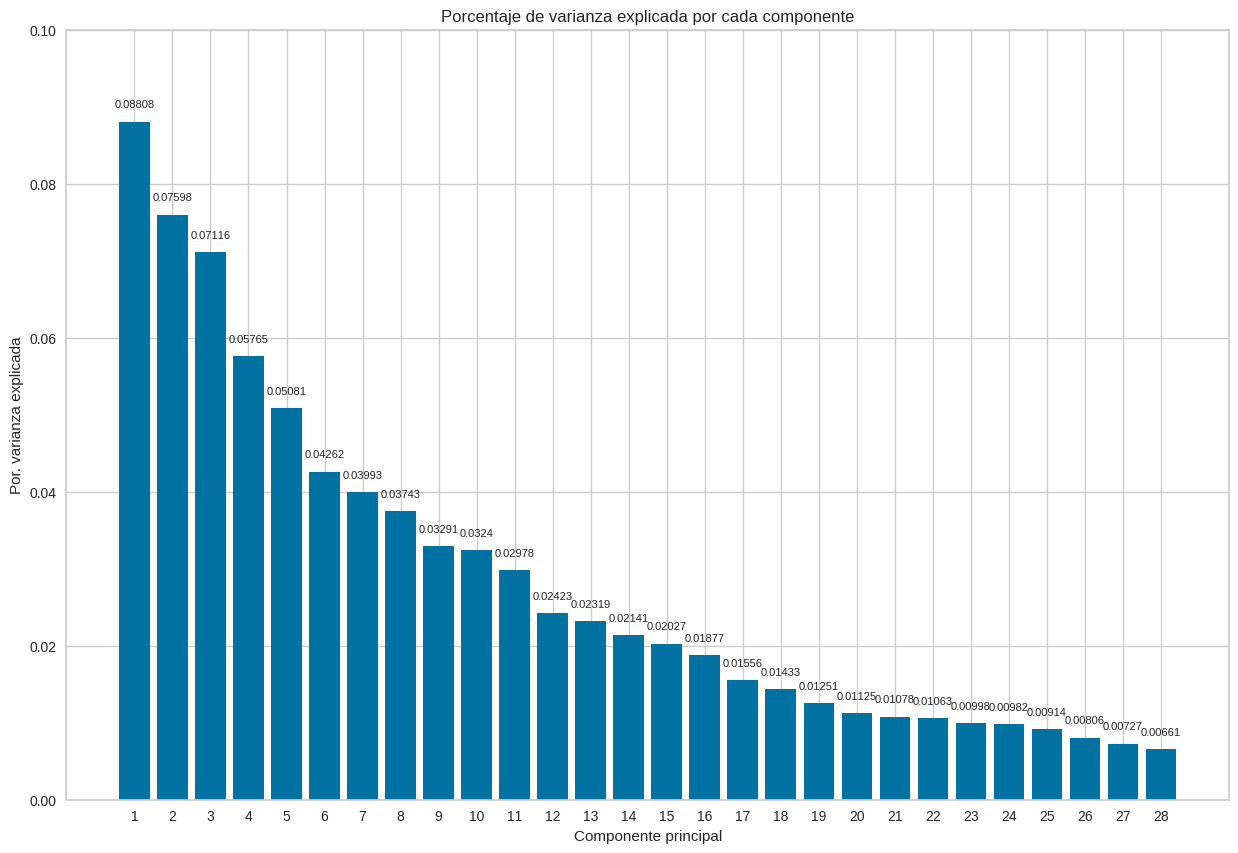

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
#print(pca_model.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15 ,10))
ax.bar(
    x      = np.arange(28) + 1,
    height = pca_model.explained_variance_ratio_[:28]
)

for x, y in zip(np.arange(28) + 1, pca_model.explained_variance_ratio_[:28]):
    label = round(y, 5)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        fontsize=8
    )

ax.set_xticks(np.arange(28) + 1)
ax.set_ylim(0, 0.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.08807943 0.16405987 0.23522094 0.2928754  0.34368709 0.38631125
 0.42624254 0.46367745 0.49659058 0.5289883  0.55877    0.58299557
 0.60618811 0.6275935  0.64786195 0.66663582 0.68219241 0.69652641
 0.70903593 0.72028591 0.73106423 0.74169825 0.75167856 0.76149918
 0.77064391 0.77869905 0.78596854 0.79258218]


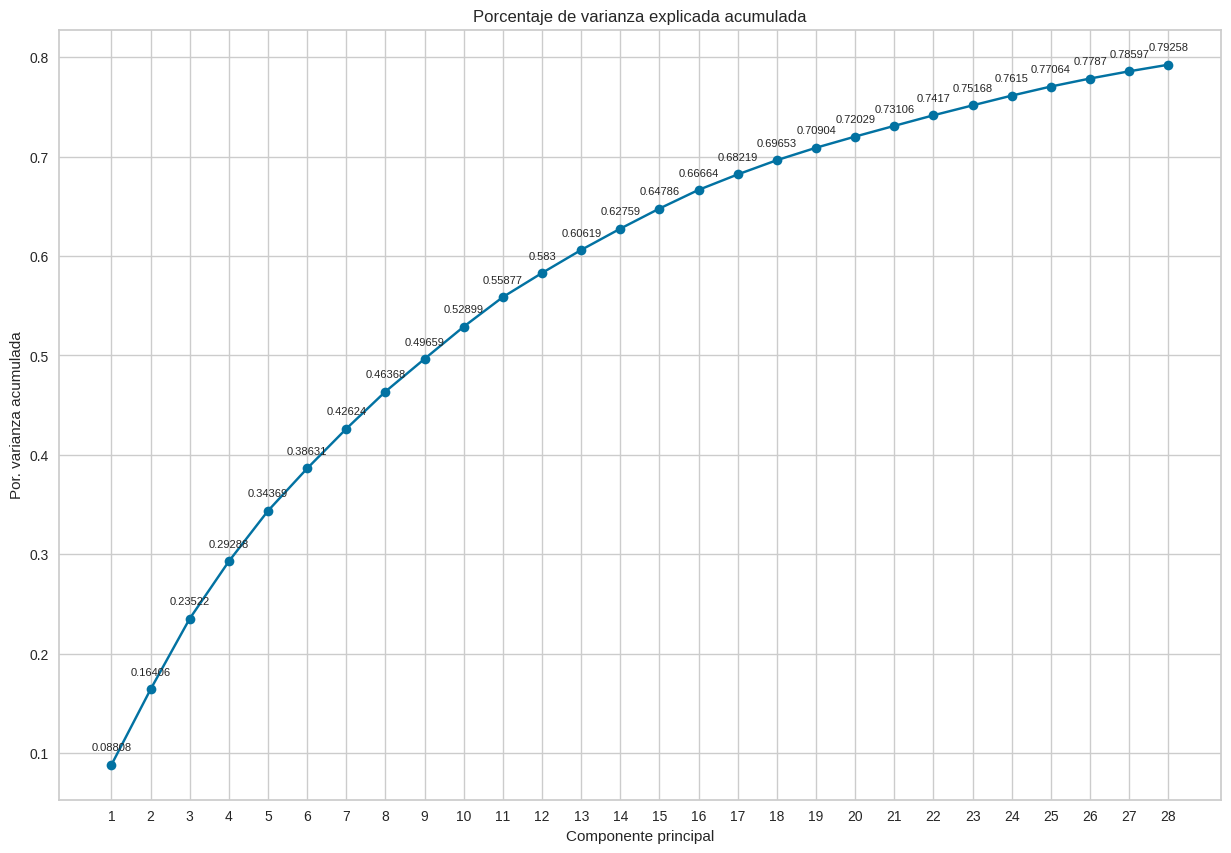

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = pca_model.explained_variance_ratio_.cumsum()[:28]
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
ax.plot(
    np.arange(28) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(28) + 1, prop_varianza_acum):
    label = round(y, 5)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        fontsize=8
    )
    

ax.set_xticks(np.arange(28) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [ ]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

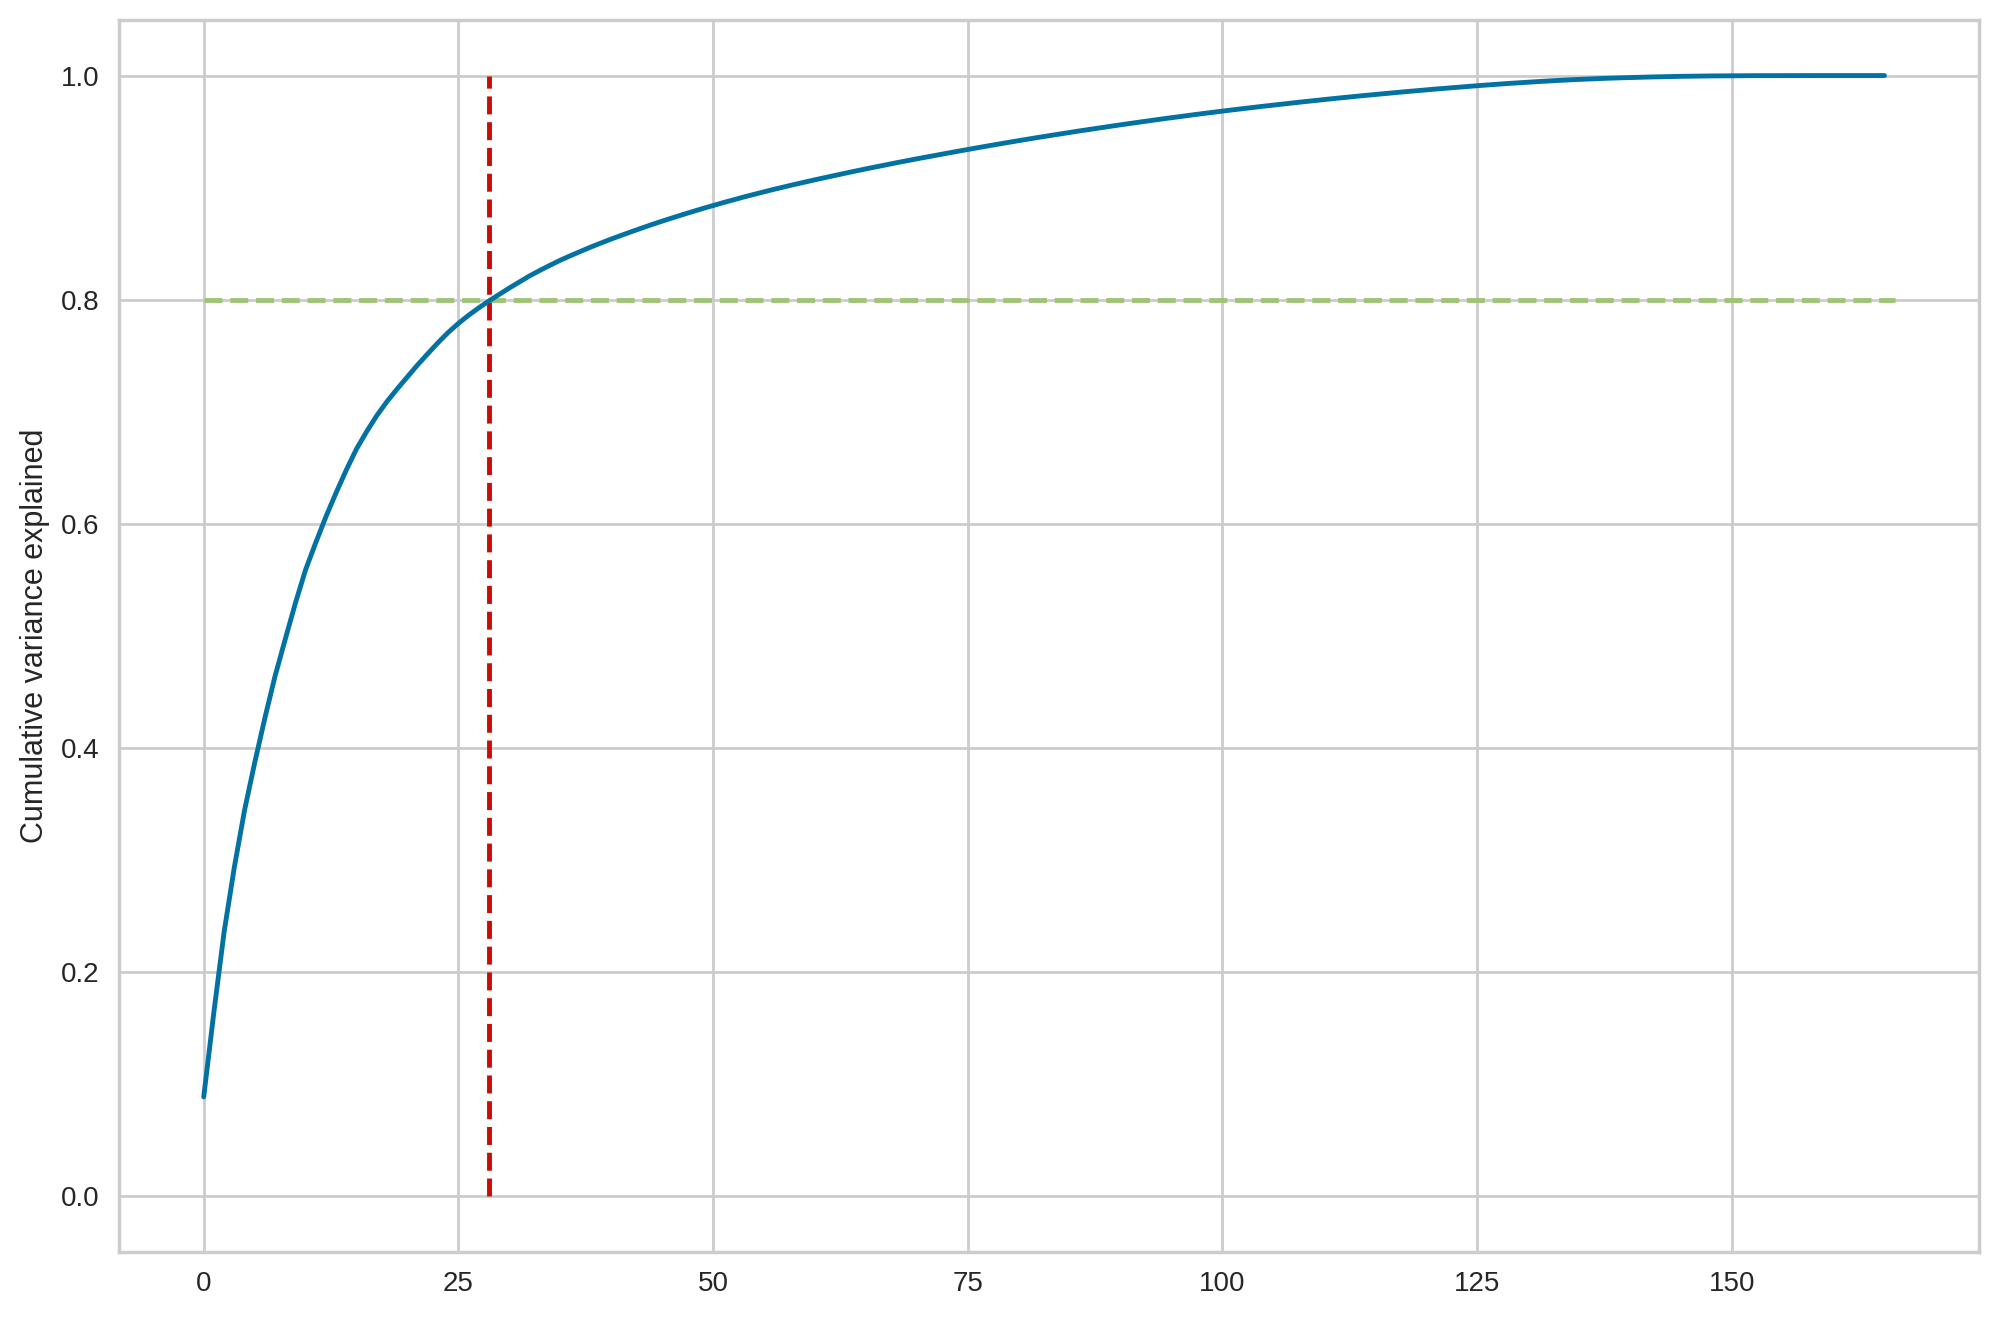

In [ ]:
fig = plt.figure(figsize=[12,8],dpi=200)
plt.vlines(x=28, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.80, xmax=166, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Se renombran las columnas de componentes

In [ ]:
pc_columns=[]
for i in range(1,29):
  pc_columns.append("PC_"+str(i))

len(pc_columns)

28

In [ ]:
pca_values=pca_model.transform(df_articles_pca)

In [ ]:
pca_values.shape

(105126, 166)

In [ ]:
pca_values=pca_values[:,:28]

In [ ]:
principal_df_articles = pd.DataFrame(data = pca_values, columns = pc_columns)


In [ ]:
principal_df_articles.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28
0,-1.132708,-0.459809,-0.320221,0.407006,-0.018220,-0.061706,0.026794,-0.375243,-0.118767,0.104456,-0.292613,-0.340666,-0.161790,0.027467,-0.172417,0.171969,-0.665867,0.420474,0.017097,0.221658,0.050292,0.133591,-0.079861,-0.223947,-0.095708,-0.132866,0.077248,0.387869
1,-0.796576,-0.276835,-0.787506,-0.155940,-0.054482,0.241582,-0.562038,-0.394710,0.685285,0.246068,-0.326134,-0.178226,-0.380865,-0.163916,-0.281017,0.023363,-0.558817,0.439879,-0.069335,0.282489,-0.093782,0.099177,0.000178,-0.227309,-0.125744,-0.124629,0.060035,0.384026
2,-0.309311,-0.507938,-0.724908,-0.671625,0.465846,0.349594,-0.303482,-0.120668,-0.583702,0.047821,-0.301449,-0.116800,-0.119469,0.012270,-0.146622,-0.233275,-0.974287,0.413198,0.058718,0.114711,0.234044,-0.244387,-0.341005,-0.077305,-0.137805,0.453677,-0.345661,0.597802
3,-1.340357,0.127823,0.234904,-0.078588,0.035564,-0.263263,0.168083,-0.566865,-0.057320,0.058435,-0.499242,0.700342,-0.235684,0.776912,0.044722,0.402937,-0.061447,-0.155560,0.040591,-0.074693,-0.076059,0.099743,-0.061454,-0.140210,0.025464,-0.057911,-0.049413,0.304897
4,-1.004225,0.310797,-0.232382,-0.641534,-0.000698,0.040026,-0.420749,-0.586331,0.746731,0.200046,-0.532763,0.862781,-0.454758,0.585529,-0.063877,0.254331,0.045603,-0.136155,-0.045841,-0.013862,-0.220133,0.065328,0.018585,-0.143573,-0.004571,-0.049674,-0.066626,0.301055


In [ ]:
principal_df_articles["article_id"]=df_articles_copy["article_id"]

In [ ]:
principal_df_articles.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,article_id
0,-1.132708,-0.459809,-0.320221,0.407006,-0.018220,-0.061706,0.026794,-0.375243,-0.118767,0.104456,-0.292613,-0.340666,-0.161790,0.027467,-0.172417,0.171969,-0.665867,0.420474,0.017097,0.221658,0.050292,0.133591,-0.079861,-0.223947,-0.095708,-0.132866,0.077248,0.387869,108775015
1,-0.796576,-0.276835,-0.787506,-0.155940,-0.054482,0.241582,-0.562038,-0.394710,0.685285,0.246068,-0.326134,-0.178226,-0.380865,-0.163916,-0.281017,0.023363,-0.558817,0.439879,-0.069335,0.282489,-0.093782,0.099177,0.000178,-0.227309,-0.125744,-0.124629,0.060035,0.384026,108775044
2,-0.309311,-0.507938,-0.724908,-0.671625,0.465846,0.349594,-0.303482,-0.120668,-0.583702,0.047821,-0.301449,-0.116800,-0.119469,0.012270,-0.146622,-0.233275,-0.974287,0.413198,0.058718,0.114711,0.234044,-0.244387,-0.341005,-0.077305,-0.137805,0.453677,-0.345661,0.597802,108775051
3,-1.340357,0.127823,0.234904,-0.078588,0.035564,-0.263263,0.168083,-0.566865,-0.057320,0.058435,-0.499242,0.700342,-0.235684,0.776912,0.044722,0.402937,-0.061447,-0.155560,0.040591,-0.074693,-0.076059,0.099743,-0.061454,-0.140210,0.025464,-0.057911,-0.049413,0.304897,110065001
4,-1.004225,0.310797,-0.232382,-0.641534,-0.000698,0.040026,-0.420749,-0.586331,0.746731,0.200046,-0.532763,0.862781,-0.454758,0.585529,-0.063877,0.254331,0.045603,-0.136155,-0.045841,-0.013862,-0.220133,0.065328,0.018585,-0.143573,-0.004571,-0.049674,-0.066626,0.301055,110065002


# **Unión de los 3 conjuntos de datos**

In [ ]:
del df_articles
del df_transactions
del df_customers 

In [ ]:
del df_articles_pca
del pca_model
del pca_values

In [ ]:
class KeepColumns(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self, df):
        return self
    def transform(self, df):
        X_new = df[self.columns]
        return X_new

In [ ]:
#creating object of KeepColumns class
keep_columns = KeepColumns(["customer_id"])
keep_columns.get_params()

{'columns': ['customer_id']}

In [ ]:
#Cambio del dataframe de clientes por las columnas a conservar
keep_columns.fit(df_custClean)
df_custClean=keep_columns.transform(df_custClean)


In [ ]:
#creating object of KeepColumns class
keep_columns2 = KeepColumns(["customer_id","article_id"])
keep_columns2.get_params()

{'columns': ['customer_id', 'article_id']}

In [ ]:
#Cambio del dataframe de transacciones por las columnas a conservar
keep_columns2.fit(df_tranClean)
df_tranClean=keep_columns2.transform(df_tranClean)

In [ ]:
class KeepLastRows(BaseEstimator, TransformerMixin):
    def __init__(self,indexMin):
        self.indexMin = indexMin
    def fit(self, df):
        return self
    def transform(self, df):
        X_new = df.iloc[self.indexMin:,:]
        return X_new

In [ ]:
#creating object of KeepLastRows class
keep_rows = KeepLastRows(17000000)
keep_rows.get_params()

{'indexMin': 17000000}

In [ ]:
#Cambio del dataframe de transacciones por las filas a conservar
keep_rows.fit(df_tranClean)
df_tranClean=keep_rows.transform(df_tranClean)


In [ ]:
class MergeDataframes(BaseEstimator, TransformerMixin):
    def __init__(self,on):
        self.on =on
    def fit(self):
        return self
    def transform(self, df1,df2):
        X_merged = pd.merge(df1,df2,on=self.on)
        return X_merged

In [ ]:
#creating object of KeepLastRows class
merge_dfs = MergeDataframes("customer_id")
merge_dfs.get_params()

{'on': 'customer_id'}

In [ ]:
#Union de los dataframes de transacciones y clientes
merge_dfs.fit()
df_merged=merge_dfs.transform(df_tranClean,df_custClean)


In [ ]:
class GetFractionSampleDataframe(BaseEstimator, TransformerMixin):
    def __init__(self,fraction):
        self.fraction = fraction
    def fit(self, df):
        return self
    def transform(self, df):
        X_sample = df.sample(frac=self.fraction)
        return X_sample

In [ ]:
#creating object of GetFractionSampleDataframe class
sample_df = GetFractionSampleDataframe(0.10)
sample_df.get_params()

{'fraction': 0.1}

In [ ]:
#Obtención de una porción del dataframe original
sample_df.fit(df_merged)
df_merged=sample_df.transform(df_merged)


In [ ]:
del df_tranClean
del df_custClean

In [ ]:
#creating object of MergeDataframes class
merge_dfs2 = MergeDataframes("article_id")
merge_dfs2.get_params()

{'on': 'article_id'}

In [ ]:
#Union de los dataframes de merged y articulos
merge_dfs2.fit()
df_merged=merge_dfs2.transform(df_merged,principal_df_articles)


In [ ]:
df_merged.shape

(1315598, 30)

In [ ]:
pipeline_merge=make_pipeline(
    keep_columns,
    keep_columns2,
    keep_rows,
    merge_dfs,
    sample_df ,
    merge_dfs2 
)

#**Aplicación de clustering**

##**Estimar el valor de k más óptimo**

In [ ]:
principal_df_articles_cluster=principal_df_articles.copy()
principal_df_articles_cluster.drop(["article_id"], axis=1, inplace=True)


In [ ]:
# HYPERPARÁMETROS DEL MODELO
kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.


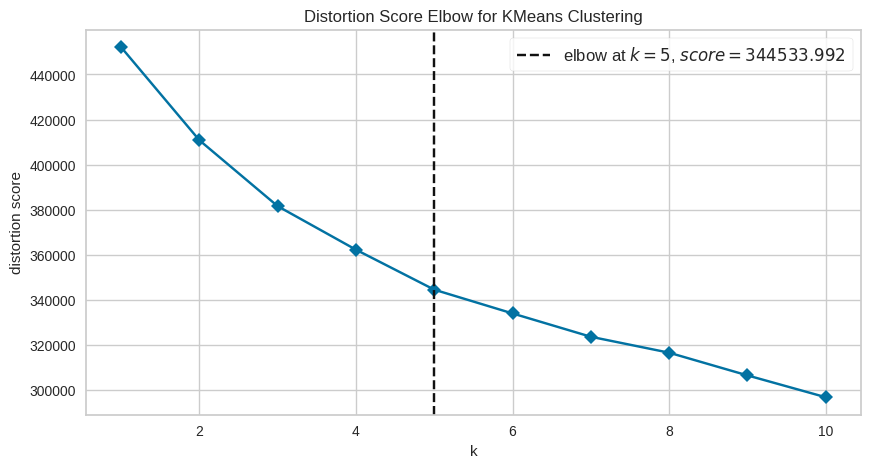

In [ ]:
model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(principal_df_articles_cluster)   #Ajusta los datos al visualizador.
  visualizer2.show()

## **Pipeline**

In [ ]:
# Entrenamiento modelo k-means con el valor óptimo encontrado de k

k = 5  #Número de grupos que se escogió después del análisis previo.

means_pipe = make_pipeline(
                KMeans(
                    n_clusters   = k,            #Se define el número de grupos.
                    init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                    n_init       = n_init,       #Número de inicializaciones aleatorias. 
                    max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                    random_state = random_seed
                )
)
means_pipe

Pipeline(steps=[('kmeans', KMeans(n_clusters=5, n_init=10, random_state=42))])

In [ ]:
X = np.array(principal_df_articles_cluster)
X.shape

(105126, 28)

In [ ]:
#Hagamos el ajuste (i.e.: encontremos los centroides).
means_pipe.fit(X)
means_pipe.named_steps

{'kmeans': KMeans(n_clusters=5, n_init=10, random_state=42)}

# **Algoritmo K-means**

In [ ]:
# Se extrae el modelo entrenado del pipeline
modelo_kmeans = means_pipe.named_steps['kmeans']

In [ ]:
# Prediciendo los clusters
labels = modelo_kmeans.predict(X)
labels.shape

(105126,)

In [ ]:
#Revisemos los centroides de cada grupo.
centroides = modelo_kmeans.cluster_centers_
centroides.shape

(5, 28)

## **Gráfica 3D** 

Debido a que se cuenta con mucha dimensionalidad, una gráfica 3D no aporta información adecuada

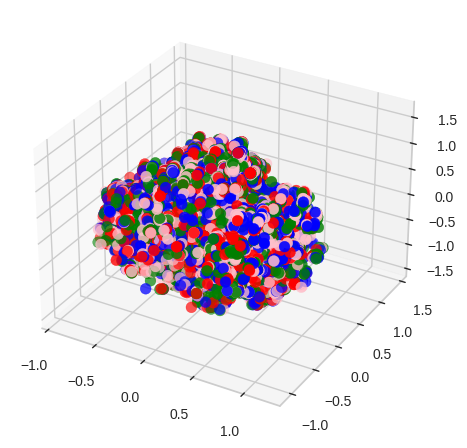

In [ ]:
from numpy.random.mtrand import randint

colores=['red','green','blue','pink','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[randint(0,4)])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 10], X[:, 20], X[:, 5], c=asignar,s=60)
ax.scatter(centroides[:, 10], centroides[:, 20], centroides[:, 5], marker='*', c=colores, s=1000)
plt.show()

In [ ]:
principal_df_articles['Cluster No'] = modelo_kmeans.labels_
principal_df_articles.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,article_id,Cluster No
0,-1.132708,-0.459809,-0.320221,0.407006,-0.018220,-0.061706,0.026794,-0.375243,-0.118767,0.104456,-0.292613,-0.340666,-0.161790,0.027467,-0.172417,0.171969,-0.665867,0.420474,0.017097,0.221658,0.050292,0.133591,-0.079861,-0.223947,-0.095708,-0.132866,0.077248,0.387869,108775015,1
1,-0.796576,-0.276835,-0.787506,-0.155940,-0.054482,0.241582,-0.562038,-0.394710,0.685285,0.246068,-0.326134,-0.178226,-0.380865,-0.163916,-0.281017,0.023363,-0.558817,0.439879,-0.069335,0.282489,-0.093782,0.099177,0.000178,-0.227309,-0.125744,-0.124629,0.060035,0.384026,108775044,1
2,-0.309311,-0.507938,-0.724908,-0.671625,0.465846,0.349594,-0.303482,-0.120668,-0.583702,0.047821,-0.301449,-0.116800,-0.119469,0.012270,-0.146622,-0.233275,-0.974287,0.413198,0.058718,0.114711,0.234044,-0.244387,-0.341005,-0.077305,-0.137805,0.453677,-0.345661,0.597802,108775051,1
3,-1.340357,0.127823,0.234904,-0.078588,0.035564,-0.263263,0.168083,-0.566865,-0.057320,0.058435,-0.499242,0.700342,-0.235684,0.776912,0.044722,0.402937,-0.061447,-0.155560,0.040591,-0.074693,-0.076059,0.099743,-0.061454,-0.140210,0.025464,-0.057911,-0.049413,0.304897,110065001,2
4,-1.004225,0.310797,-0.232382,-0.641534,-0.000698,0.040026,-0.420749,-0.586331,0.746731,0.200046,-0.532763,0.862781,-0.454758,0.585529,-0.063877,0.254331,0.045603,-0.136155,-0.045841,-0.013862,-0.220133,0.065328,0.018585,-0.143573,-0.004571,-0.049674,-0.066626,0.301055,110065002,2


#**Exploración del modelo**

In [ ]:
copy =  pd.DataFrame()
copy['article_id']=principal_df_articles['article_id'].values
copy['cluster'] = principal_df_articles['Cluster No'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,24701
1,green,21530
2,blue,24497
3,pink,23637
4,yellow,10761


In [ ]:
#vemos las posiciones de los representantes del grupo en el array X, los articulos más cercano a cada centroid
closest, _ = pairwise_distances_argmin_min(modelo_kmeans.cluster_centers_, X)
closest

array([68740, 21085, 48481, 45270, 88596])

In [ ]:
# Articulos que están más cerca a los centroids de cada grupo que podríamos decir que tienen atributos que representan a cada cluster
articles=principal_df_articles['article_id'].values
for row in closest:
    print(articles[row])

756419002
593232001
693342001
683906005
835653002


In [ ]:
df_articles = pd.read_csv('articles.csv',na_values='?')

In [ ]:
#Representante cluster 0 - red
df_articles[df_articles['article_id']==756419002]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
69152,756419002,756419,Matchi,258,Blouse,Garment Upper body,1010016,Solid,19,Greenish Khaki,1,Dusty Light,20,Khaki green,8713,Young Girl Dresses,I,Children Sizes 134-170,4,Baby/Children,77,Young Girl,1014,Dresses/Skirts girls,"Blouse in a viscose weave with ribbing around the neckline and short, flounced sleeves with broderie anglaise."


In [ ]:
#Representante cluster 1 - green
df_articles[df_articles['article_id']==593232001]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
21274,593232001,593232,Stone Polo,254,Top,Garment Upper body,1010015,Sequin,9,Black,4,Dark,5,Black,3090,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,"Transparent, fitted polo-neck jumper in mesh with sparkly stones, with long sleeves and a raw-edge hem."


In [ ]:
#Representante cluster 2 - blue
df_articles[df_articles['article_id']==693342001]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
48847,693342001,693342,EDC BIANCA JUMPSUIT,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,3090,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,"Sleeveless jumpsuit in velvet with a lace-trimmed V-neck, narrow shoulder straps and a seam at the waist. Side pockets, wide elastication at the back and tapered legs. Partly lined."


In [ ]:
#Representante cluster 3 - pink
df_articles[df_articles['article_id']==683906005]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
45616,683906005,683906,Lucy party top,258,Blouse,Garment Upper body,1010002,Application/3D,73,Dark Blue,4,Dark,2,Blue,8713,Young Girl Dresses,I,Children Sizes 134-170,4,Baby/Children,77,Young Girl,1014,Dresses/Skirts girls,Sleeveless top in woven fabric with sequined mesh at the front and an opening with a button at the back of the neck.


In [ ]:
#Representante cluster 4 - yellow
df_articles[df_articles['article_id']==835653002]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
89010,835653002,835653,Roma Straw Hat,76,Hat/brim,Accessories,1010016,Solid,1,Other,6,Undefined,14,undefined,3519,Gloves/Hats,C,Ladies Accessories,1,Ladieswear,65,Womens Big accessories,1019,Accessories,Hat in braided paper straw with a fringe-trimmed brim. Width of brim 11 cm.


#**Recomendacion a clientes a partir del modelo**

Con el método **recommendations** se busca recomendar dado un usuario, 5 artículos de cada cluster diferente a los que peertenezcan los artículos que haya comprado anteriormente

In [ ]:
def recommendations(clientID):
  df_client = df_merged[df_merged['customer_id']==clientID]
  clusters = []
  df_recomended = pd.DataFrame()   
  articles = pd.DataFrame()   
  for i in df_articles.columns:
    df_recomended[i] = [] 
  for i in principal_df_articles.columns:
    articles[i] = [] 
  for index, transaction in df_client.iterrows():
    ar_id=transaction[1]
    row=principal_df_articles[principal_df_articles["article_id"]==ar_id]
    cluster=row["Cluster No"].values[0]
    clusters.append(cluster)
  unique_clusters = list(set(clusters))
  for cluster in unique_clusters:
    row = principal_df_articles[principal_df_articles["Cluster No"] == cluster].sample(5)
    articles=articles.append(row)
  for index, article in articles.iterrows():
    df_recomended = df_recomended.append(df_articles[df_articles['article_id']==article[-2]], ignore_index=True)
  return df_recomended,df_client 

Se prueba con un cliente existente aleatorio

In [ ]:
customer = df_merged.sample(1)["customer_id"].values[0]
print(customer)

022dccfdb3b82f30ec09754a53c8cf5f08c3ad3960702d35cb08e43c3d643e11


El método **purchasedArticles** permite obtener aquellos artículos que ha comprado el cliente, para comparar aquello que se la ha recomendado con lo que está en su historial de compras

In [ ]:
def purchasedArticles(df):
  df_purchased = pd.DataFrame()
  for i in df_articles.columns:
    df_purchased[i] = [] 
  for index, article in df.iterrows():
    df_purchased = df_purchased.append(df_articles[df_articles['article_id']==article[1]], ignore_index=True)
  return df_purchased  

In [ ]:
df_recomended, df_client = recommendations(customer)

<ipython-input-108-6743229b53dc>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  articles=articles.append(row)
<ipython-input-108-6743229b53dc>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  articles=articles.append(row)
<ipython-input-108-6743229b53dc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recomended = df_recomended.append(df_articles[df_articles['article_id']==article[-2]], ignore_index=True)


In [ ]:
df_purchased = purchasedArticles(df_client)
df_purchased.head()

<ipython-input-121-d33e8e64b06a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_purchased = df_purchased.append(df_articles[df_articles['article_id']==article[1]], ignore_index=True)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,599719021.0,599719.0,Hudson shorts,274.0,Shorts,Garment Lower body,1010016.0,Solid,73.0,Dark Blue,4.0,Dark,2.0,Blue,1410.0,Shorts & Skirts,A,Ladieswear,1.0,Ladieswear,6.0,Womens Casual,1025.0,Shorts,"Short shorts in woven fabric with a zip fly and button, side pockets and fake welt back pockets."
1,488561021.0,488561.0,Teddy jogger.,274.0,Shorts,Garment Lower body,1010024.0,Chambray,9.0,Black,4.0,Dark,5.0,Black,5658.0,Shorts,F,Menswear,3.0,Menswear,21.0,Contemporary Casual,1025.0,Shorts,"Knee-length shorts in soft washed cotton with an elasticated drawstring waist, fake fly, side pockets and welt back pockets with a button."
2,769483005.0,769483.0,BRAD SUPER FANCY,59.0,Swimwear bottom,Swimwear,1010001.0,All over pattern,71.0,Light Blue,3.0,Light,2.0,Blue,9984.0,Swimwear,F,Menswear,3.0,Menswear,26.0,Men Underwear,1018.0,Swimwear,"Swim shorts in a printed weave with an elasticated drawstring waist, side pockets, a back pocket and short legs with slits in the sides. Soft mesh inner shorts."
3,589521001.0,589521.0,Niko 5-p boxer BB,286.0,Underwear bottom,Underwear,1010016.0,Solid,72.0,Blue,7.0,Medium,2.0,Blue,4225.0,Young Boy UW/NW,I,Children Sizes 134-170,4.0,Baby/Children,72.0,Boys Underwear & Basics,1017.0,"Under-, Nightwear","Boxer shorts in cotton jersey with short legs, an elasticated waist and lined front."


In [ ]:
df_recomended.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,650735003.0,650735.0,JANE 2p trousers BG,272.0,Trousers,Garment Lower body,1010001.0,All over pattern,9.0,Black,4.0,Dark,5.0,Black,7930.0,Young Girl Jersey Basic,I,Children Sizes 134-170,4.0,Baby/Children,79.0,Girls Underwear & Basics,1002.0,Jersey Basic,"Joggers in soft organic cotton jersey with a frill-trimmed, elasticated drawstring waist and ribbed hems."
1,870524002.0,870524.0,Meadow,272.0,Trousers,Garment Lower body,1010001.0,All over pattern,9.0,Black,4.0,Dark,5.0,Black,7616.0,Kids Girl Jersey Fancy,H,Children Sizes 92-140,4.0,Baby/Children,76.0,Kids Girl,1005.0,Jersey Fancy,"Ankle-length treggings in cotton sweatshirt fabric. Skinny fit with a ribbed, easy pull-on, elasticated waist. Fake fly, fake front pockets and real back pockets."
2,916823001.0,916823.0,Shelly Brazilian 3-pack,286.0,Underwear bottom,Underwear,1010021.0,Lace,9.0,Black,4.0,Dark,5.0,Black,3937.0,UW,D,Divided,2.0,Divided,51.0,Divided Basics,1017.0,"Under-, Nightwear","Brazilian briefs in lace with a low waist, lined gusset and high cut at the back."
3,504196001.0,504196.0,Cosmo maxi,265.0,Dress,Garment Full body,1010010.0,Melange,7.0,Grey,1.0,Dusty Light,12.0,Grey,1344.0,Dresses,D,Divided,2.0,Divided,53.0,Divided Collection,1013.0,Dresses Ladies,"Calf-length jersey dress in a viscose blend. Wide neckline, tie shoulder straps and a slit at the back."
4,710312002.0,710312.0,OL ROSE SCALLOP PQ sandal,91.0,Sandals,Shoes,1010016.0,Solid,6.0,Light Grey,1.0,Dusty Light,12.0,Grey,3040.0,Premium Quality,C,Ladies Accessories,1.0,Ladieswear,64.0,Womens Shoes,1020.0,Shoes,Mules with scallop-edged straps. Leather linings and insoles and smooth ethylene-vinyl acetate (EVA) soles.
